## **Business Scenario & Outcomes**
Your company serving global B2B customers; needs to ensure timely, efficient, and cost-effective fulfillment of large-scale industrial equipment orders. These transactions often require balancing customer demands, fluctuating inventory levels, supplier constraints, and complex delivery logistics.

Value:

Faster, more accurate fulfillment commitments for high-value clients.
Reduced delivery costs through intelligent logistics planning.
Improved client trust through transparency and responsiveness.



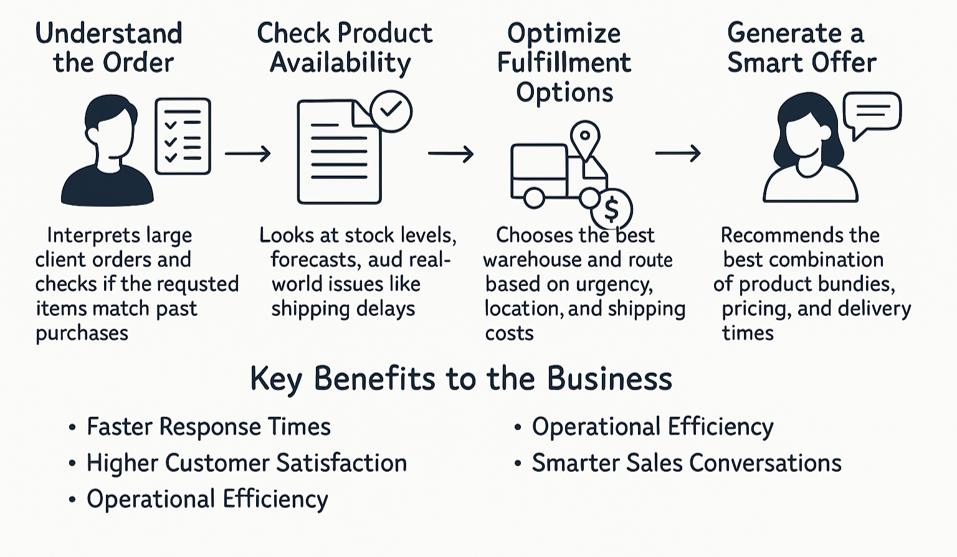

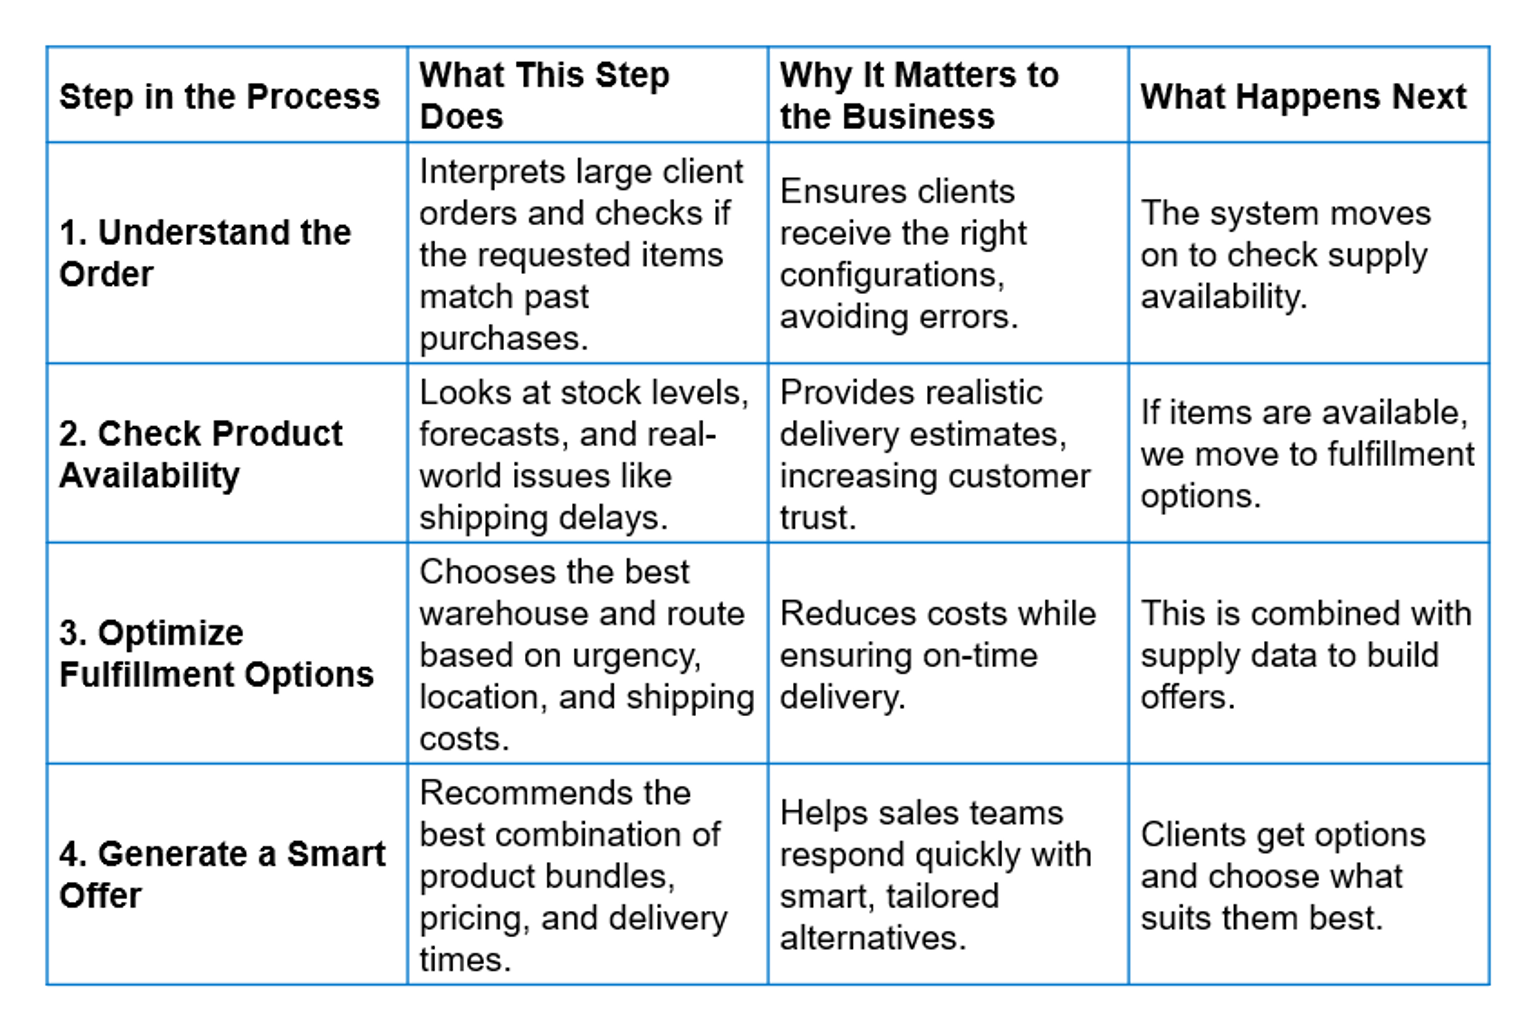

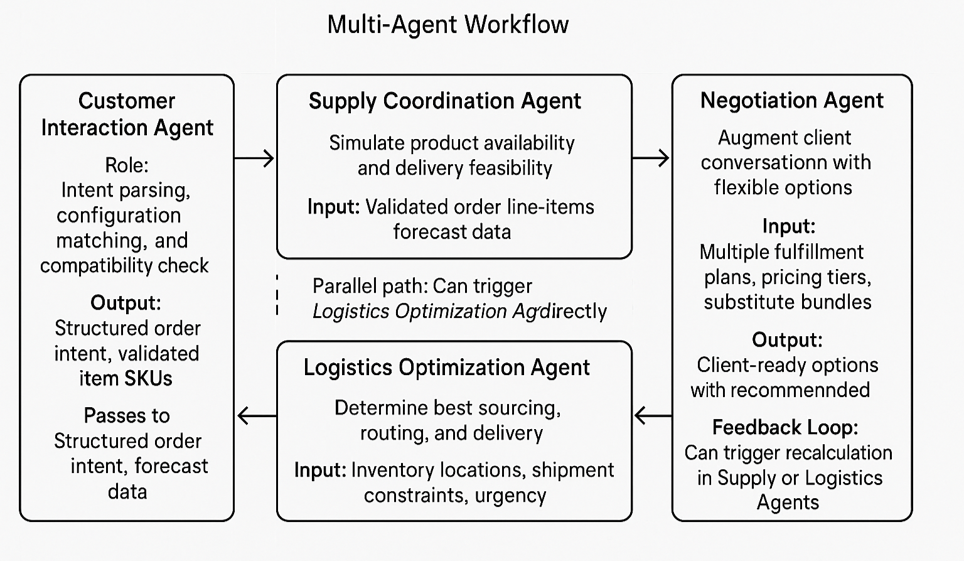

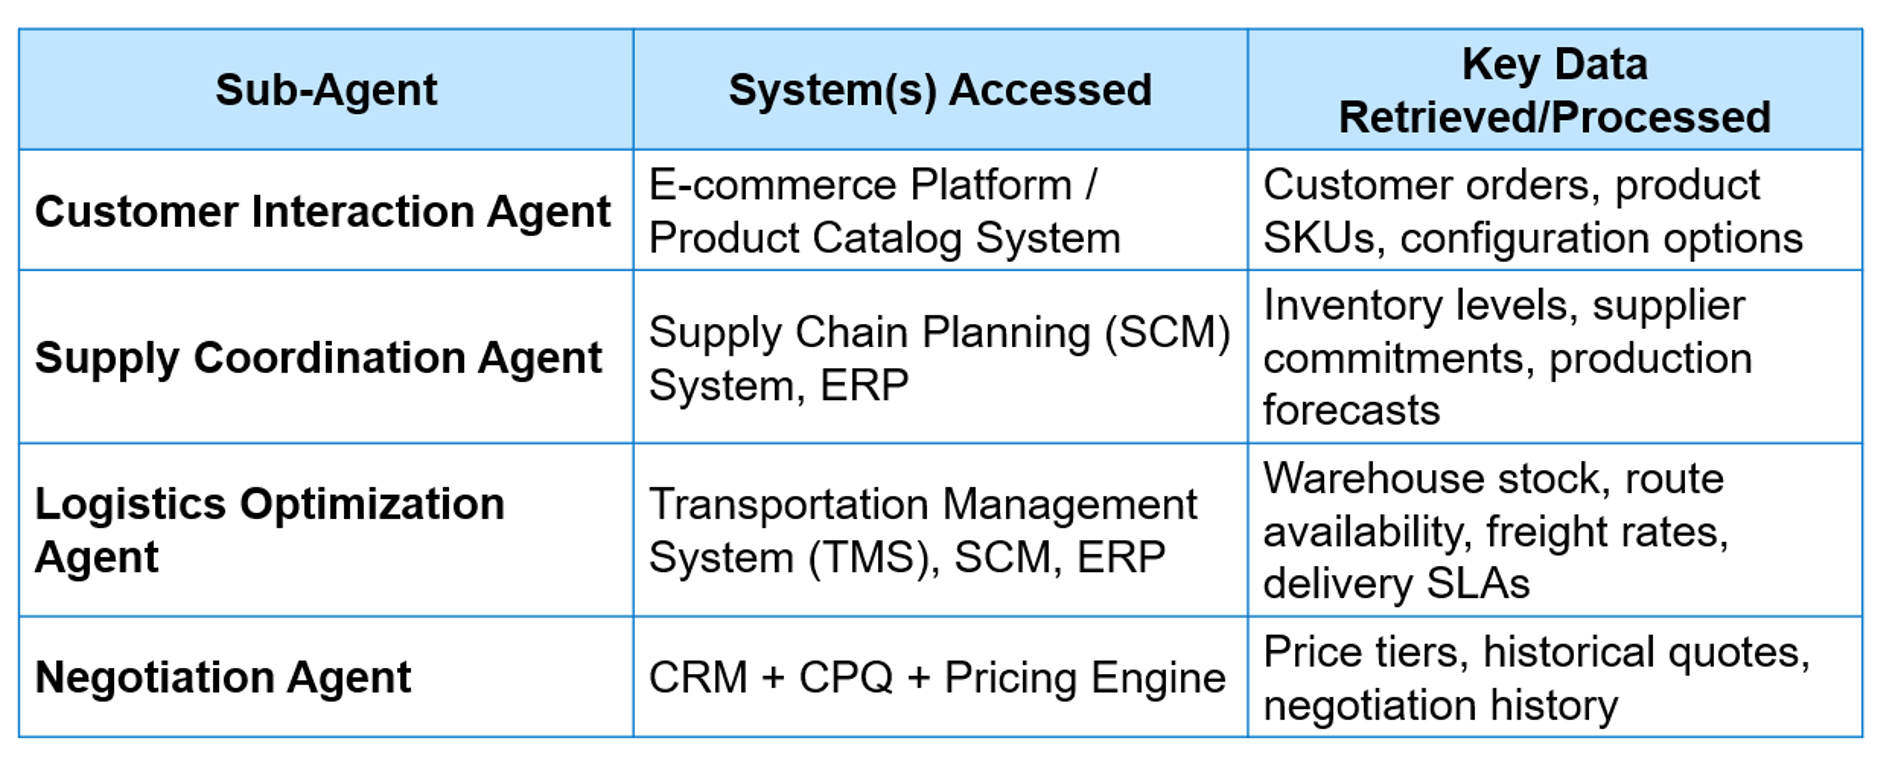

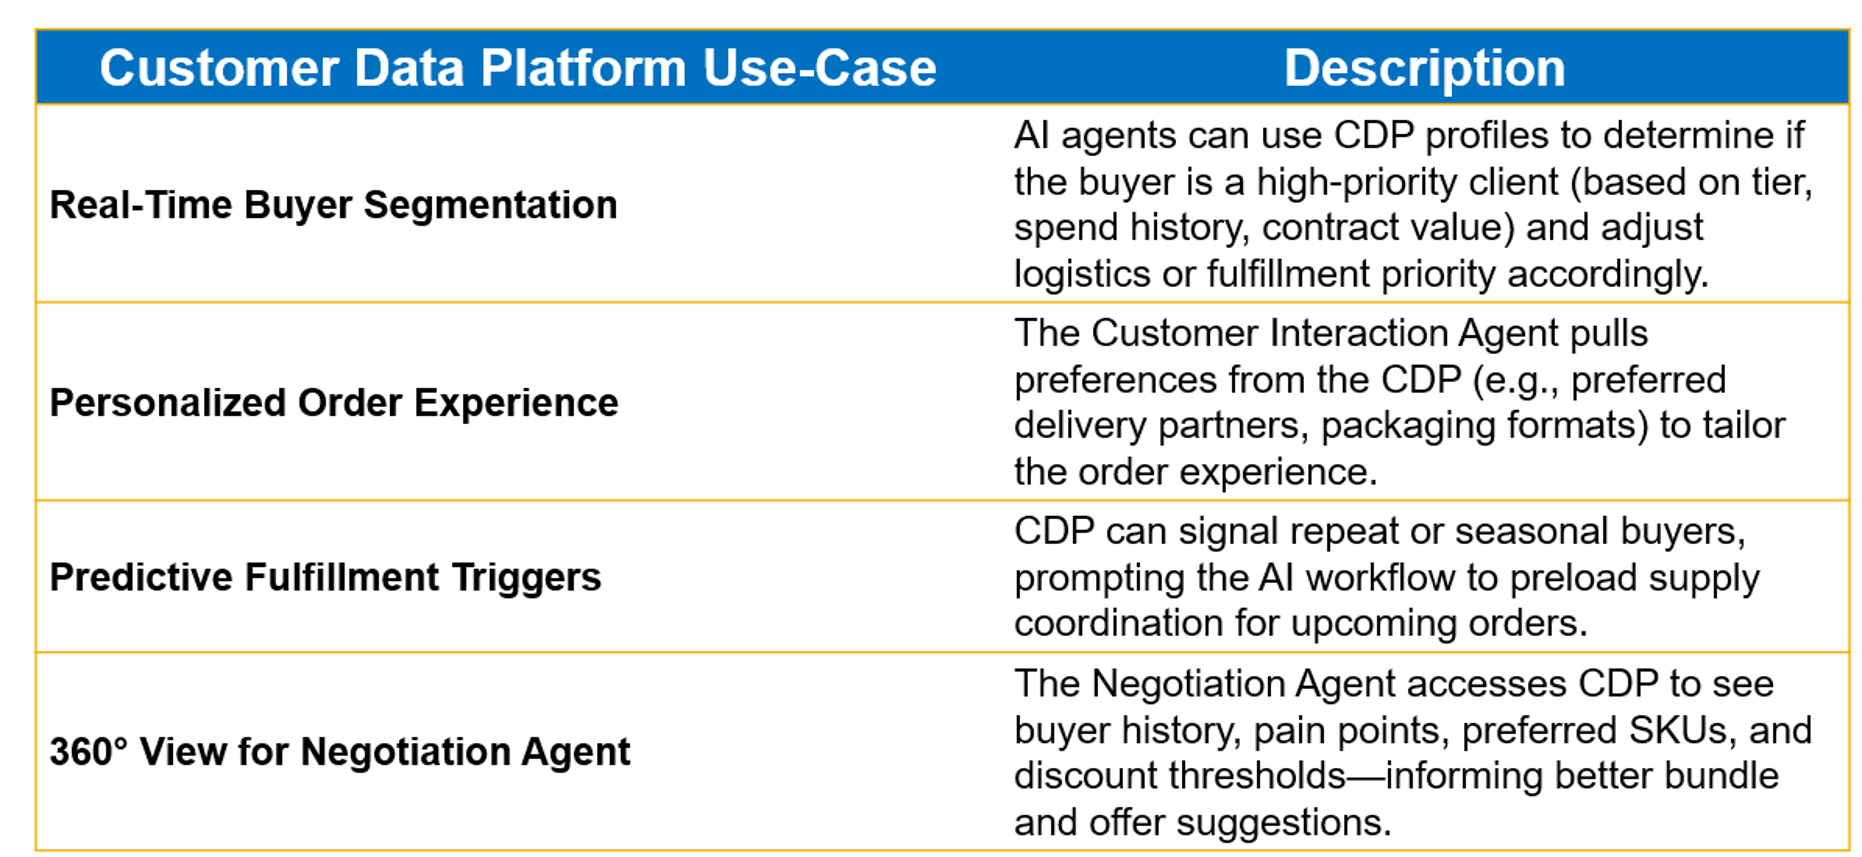

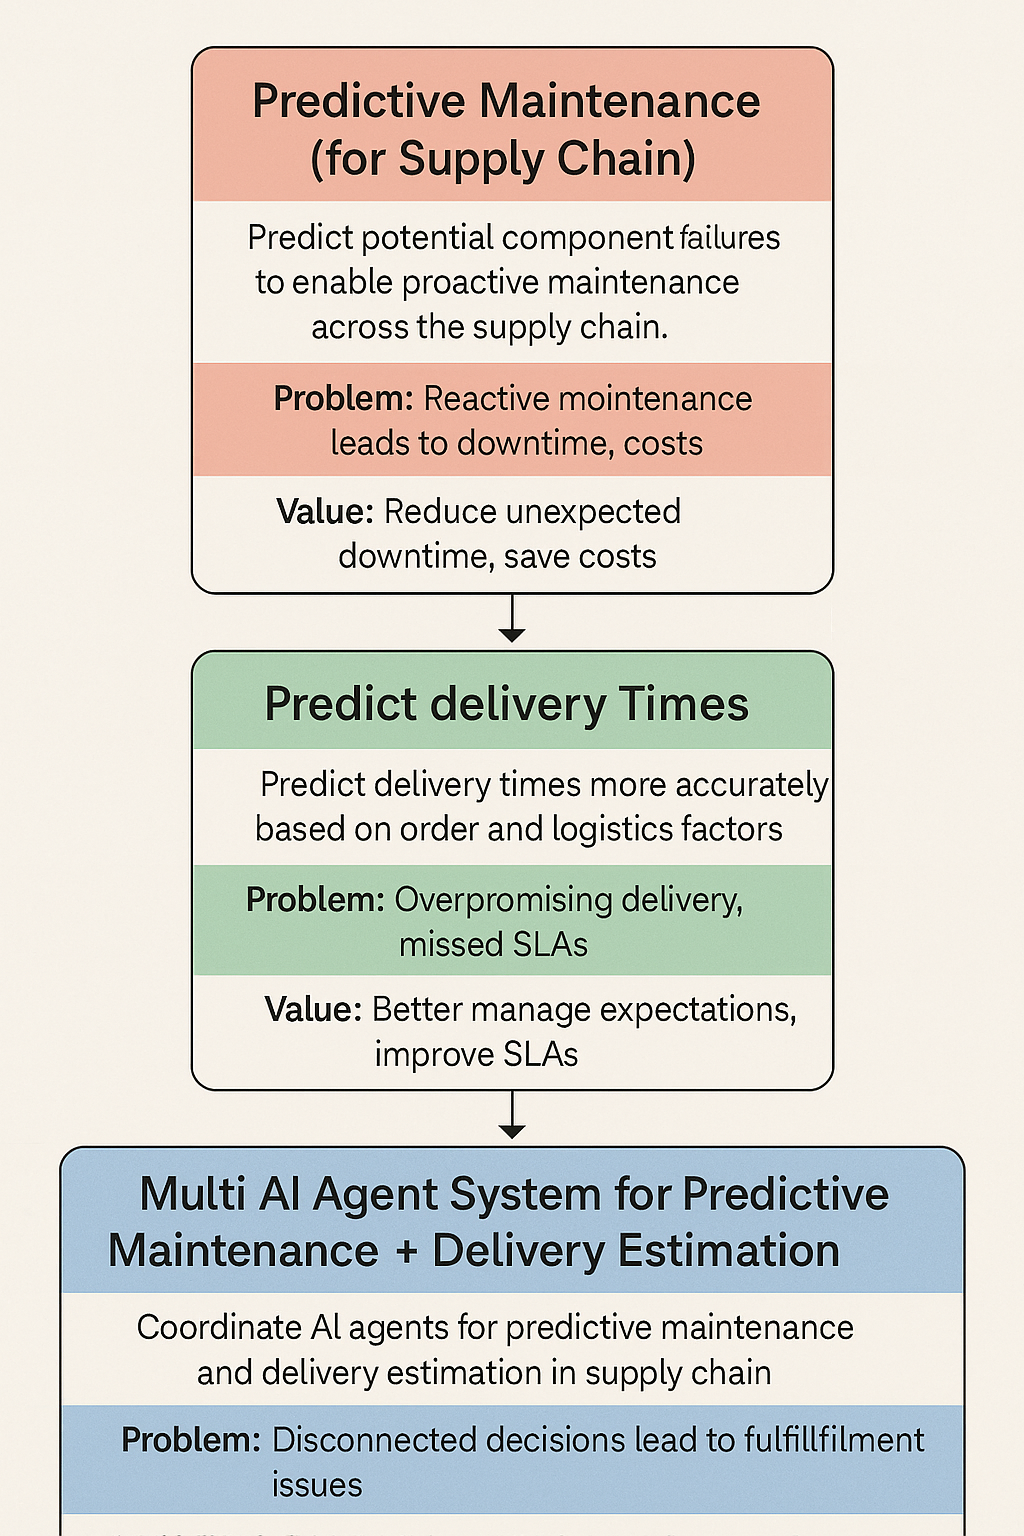

## **Installation & Imports**

Dependency Installation: this section makes sure your notebook has all the building blocks it needs by installing or upgrading the core AI and orchestration libraries—LangChain for chaining prompts and tools, LangGraph for stateful workflow graphs, and their related extensions—so that every subsequent piece of code can call into these frameworks without missing dependencies.
Standard Library Imports: here we bring in the everyday Python modules—operating-system utilities, logging for debug messages, data structures from Pydantic, Pandas for tables, Matplotlib and NetworkX for charts and graphs, NumPy for calculations, and standard datetime and typing helpers—so that the rest of the code can read and manipulate data, draw visuals, and define clear models.
LangChain Imports: this section loads the parts of LangChain that let us treat an LLM like a reusable agent—wrapping the OpenAI chat model, defining message formats (human vs. system vs. AI), building prompt templates, parsing outputs, and wiring in tools and agent executors—so we can build self-directed “ReAct” agents that call functions and think step by step.
LangGraph Imports: here we import the StateGraph engine from LangGraph along with an optional SQLite saver so we can stitch multiple agent nodes into a single in-memory workflow, track state as it flows through each step, and (if desired) checkpoint that state to disk.
Logging Configuration: this section sets up a consistent log format, log level, and a named logger so that every part of the system can record what it’s doing or where it hits problems, making it easy to trace the automated order pipeline’s execution in real time.



In [ ]:
# =================== SECTION 1A: DEPENDENCY INSTALLATION ===================
# Install or upgrade to the latest versions of LangChain, LangGraph, and related packages
!pip install --upgrade langchain langchain-openai langchain-community langgraph langgraph-checkpoint-sqlite

# =================== SECTION 1B: STANDARD LIBRARY IMPORTS ===================
import os
import logging
from pydantic import BaseModel
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from datetime import datetime, timedelta
from typing import Optional, List, Dict, Any, Tuple
from pydantic import BaseModel, Field

# =================== SECTION 1C: LANGCHAIN IMPORTS ===================
# Chat models
from langchain.chat_models import ChatOpenAI
# Message schemas
from langchain.schema import HumanMessage, SystemMessage, AIMessage
# Prompt templates
from langchain.prompts import ChatPromptTemplate
# Output parsers (path may vary by version)
try:
   from langchain.output_parsers import StrOutputParser
except ImportError:
   try:
       from langchain.output_parsers.string import StrOutputParser
   except ImportError:
       from langchain_core.output_parsers.string import StrOutputParser

# Tools and agent orchestration
from langchain.tools import tool, BaseTool
from langchain.agents import initialize_agent, AgentType
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts.chat import (
   ChatPromptTemplate,
   SystemMessagePromptTemplate,
   HumanMessagePromptTemplate,
)

# =================== SECTION 1D: LANGGRAPH IMPORTS ===================
from langgraph.graph import StateGraph, END
try:
   from langgraph.checkpoint.sqlite import SqliteSaver
except ImportError:
   raise ImportError("langgraph-checkpoint-sqlite not installed; run pip install langgraph-checkpoint-sqlite")

# =================== SECTION 1E: LOGGING CONFIGURATION ===================
logging.basicConfig(
   format="%(asctime)s %(levelname)s %(name)s ▶ %(message)s",
   level=logging.INFO
)
logger = logging.getLogger(__name__)
logger.info("Imports and basic setup complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


## **API Set-up**

API SETUP: this piece retrieves your OpenAI API key—either from environment variables or Colab secrets—stores it in os.environ, and initializes the GPT-4 chat model wrapper, ensuring that every agent has valid credentials to generate and analyze text.

In [ ]:
# =================== SECTION 2: API KEY SETUP ===================
# Retrieve OpenAI API key from environment or Colab secrets
from google.colab import userdata
#from langchain_openai import ChatOpenAI

# OpenAI API connection (from your Colab secrets)
colab_openai_api_key = userdata.get('OPENAI_API_KEY')

# Initialize the LLM
llm = ChatOpenAI(
   model="gpt-4",
   temperature=0.2,
   api_key=colab_openai_api_key
)
os.environ['OPENAI_API_KEY'] = colab_openai_api_key
openai_key = colab_openai_api_key

<ipython-input-10-f79b8b96148d>:10: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


## **Data Management**

Simulated Data: this section builds the four core Pandas tables—orders (who ordered what and when), inventory (stock levels, reorder thresholds, costs, locations), logistics (shipping and express options per region), and client-tier profiles—so subsequent functions and agents have realistic data to read, analyze, and report on.
CDP Profiles: here we enrich the client-tier table with Customer Data Platform details—preferred carriers, packaging formats, full order histories, known pain points, favorite SKUs, and discount thresholds—and define helper functions to surface buyer priorities, personalization settings, predictive fulfillment triggers, and negotiation profiles.



In [ ]:
# =================== SECTION 3A: TRANSACTIONAL DATA ===================
# Order data: Contains information about client orders
data_order = pd.DataFrame({
   "Order ID": [101, 102, 103],
   "Client": ["Global Aero", "SkyTech", "Orbit Systems"],
   "Requested Items": [["AX-900 Turbine", "Fuel Pump"], ["Wing Bolt Set"], ["Hydraulic Cylinder", "Nose Gear"]],
   "Urgency": ["High", "Medium", "High"],
   "Region": ["North America", "Europe", "Asia-Pacific"],
   "Order Date": [datetime(2025, 4, 10), datetime(2025, 4, 15), datetime(2025, 4, 18)]
})

# Inventory data: Current stock levels and lead times for each SKU
data_inventory = pd.DataFrame({
   "SKU": ["AX-900 Turbine", "Fuel Pump", "Wing Bolt Set", "Hydraulic Cylinder", "Nose Gear"],
   "Location": ["Chicago", "Dallas", "Berlin", "Shanghai", "Tokyo"],
   "Stock": [4, 10, 0, 7, 2],
   "Lead Time (days)": [5, 3, 10, 2, 7],
   "Reorder Point": [3, 5, 2, 4, 2],
   "Cost": [2500, 800, 350, 1200, 900]
})

# Logistics data: Shipping options and costs by region
data_logistics = pd.DataFrame({
   "Region": ["North America", "Europe", "Asia-Pacific"],
   "Shipping Cost": [500, 1200, 1700],
   "Delivery Days": [3, 5, 7],
   "Express Option": [True, True, False],
   "Express Cost": [900, 2000, 3000], # Note: Made Express Cost for Asia-Pacific non-zero for consistency, though option is False
   "Express Days": [1, 2, 3]
})

# =================== SECTION 3B: CUSTOMER DATA PLATFORM (CDP) PROFILES ===================

# Client tier data to represent CDP information
data_client_tiers = pd.DataFrame({
   "Client": ["Global Aero", "SkyTech", "Orbit Systems", "AeroTech", "Sky Industries"],
   "Tier": ["Platinum", "Gold", "Platinum", "Silver", "Bronze"],
   "Annual Spend": [1500000, 750000, 2000000, 250000, 100000],
   "Years Active": [10, 5, 15, 2, 1],
   "Payment Terms": [45, 30, 60, 15, 15]
})

# Re-define (or append to) your existing client‐tier DataFrame
cdp_profiles = pd.DataFrame({
   "Client": ["Global Aero", "SkyTech", "Orbit Systems", "AeroTech", "Sky Industries"],
   "Preferred Delivery Partner": ["DHL", "FedEx", "UPS", "DHL", "FedEx"],
   "Packaging Format": ["Crate", "Box", "Pallet", "Box", "Crate"],
   "Order History": [
       [datetime(2024,4,10), datetime(2023,4,12), datetime(2022,4,9)],
       [datetime(2025,1,15)],
       [datetime(2024,4,18), datetime(2023,4,20)],
       [datetime(2025,2,1)],
       [datetime(2025,3,5)]
   ],
   "Pain Points": [
       "Lead time variability", "Packaging damage", "Delayed shipping", "Expensive freight", "Complex billing"
   ],
   "Preferred SKUs": [
       ["AX-900 Turbine", "Fuel Pump"], ["Wing Bolt Set"], ["Hydraulic Cylinder"], ["Nose Gear"], ["Fuel Pump"]
   ],
   "Discount Threshold (%)": [0.15, 0.10, 0.15, 0.05, 0.02]
})

# 1) Real-Time Buyer Segmentation
def get_buyer_priority(client_name: str) -> str:
   tier = data_client_tiers.loc[data_client_tiers["Client"] == client_name, "Tier"].iloc[0]
   spend = data_client_tiers.loc[data_client_tiers["Client"] == client_name, "Annual Spend"].iloc[0]
   if tier == "Platinum" or spend > 1_000_000:
       return "High-Priority"
   elif tier == "Gold":
       return "Medium-Priority"
   else:
       return "Standard-Priority"

# 2) Personalized Order Experience
def get_customer_preferences(client_name: str) -> dict:
   profile = cdp_profiles.set_index("Client").loc[client_name]
   return {
       "Preferred Delivery Partner": profile["Preferred Delivery Partner"],
       "Packaging Format": profile["Packaging Format"]
   }

# 3) Predictive Fulfillment Triggers
def predictive_fulfillment_clients(threshold_days: int = 30) -> list:
   today = datetime.now()
   triggers = []
   for _, row in cdp_profiles.iterrows():
       for past in row["Order History"]:
           if abs((today - past).days) <= threshold_days:
               triggers.append(row["Client"])
               break
   return triggers

# 4) 360° View for Negotiation Agent
def get_negotiation_profile(client_name: str) -> dict:
   tier = data_client_tiers.set_index("Client").loc[client_name, "Tier"]
   discount = cdp_profiles.set_index("Client").loc[client_name, "Discount Threshold (%)"]
   pain = cdp_profiles.set_index("Client").loc[client_name, "Pain Points"]
   skus = cdp_profiles.set_index("Client").loc[client_name, "Preferred SKUs"]
   return {
       "Tier": tier,
       "Discount Threshold": f"{discount*100:.0f}%",
       "Pain Points": pain,
       "Preferred SKUs": skus
   }

# Example usage:
print("Buyer Priority for Global Aero:", get_buyer_priority("Global Aero"))
print("Preferences for SkyTech:", get_customer_preferences("SkyTech"))
print("Predictive fulfillment triggers (30-day window):", predictive_fulfillment_clients())
print("Negotiation profile for Orbit Systems:", get_negotiation_profile("Orbit Systems"))

Buyer Priority for Global Aero: High-Priority
Preferences for SkyTech: {'Preferred Delivery Partner': 'FedEx', 'Packaging Format': 'Box'}
Predictive fulfillment triggers (30-day window): []
Negotiation profile for Orbit Systems: {'Tier': 'Platinum', 'Discount Threshold': '15%', 'Pain Points': 'Delayed shipping', 'Preferred SKUs': ['Hydraulic Cylinder']}


## **Langchain Tools**

LangChain Tools: in this section, each key business operation (order lookup, inventory check, compatibility test, supply simulation, route optimization, negotiation bundle) is wrapped in an @tool decorator, turning your plain Python functions into callable building blocks that AI agents can invoke automatically as they reason through each order.

In [ ]:
# =================== SECTION 4: LANGCHAIN TOOLS ===================
@tool
def get_order_summary() -> str:
   """
   Retrieve current order queue with details about clients and requested items.
   Returns a formatted markdown table of all active orders.
   """
   logger.info("Tool: get_order_summary called.")
   return data_order.to_markdown(index=False)

@tool
def get_order_details(order_id: int) -> str:
   """
   Get detailed information about a specific order identified by its ID.
   Requires the 'order_id' as input.
   """
   logger.info(f"Tool: get_order_details called for Order ID: {order_id}")
   try:
       order_id_int = int(order_id) # Ensure it's an integer
       order = data_order[data_order['Order ID'] == order_id_int]
       if order.empty:
           return f"Order ID {order_id_int} not found."
       items = ", ".join(order['Requested Items'].iloc[0])
       date = order['Order Date'].iloc[0].strftime("%Y-%m-%d")
       return f"""
**Order ID**: {order_id_int}
**Client**: {order['Client'].iloc[0]}
**Order Date**: {date}
**Region**: {order['Region'].iloc[0]}
**Urgency**: {order['Urgency'].iloc[0]}
**Requested Items**: {items}
"""
   except ValueError:
       logger.error(f"Error in get_order_details: Invalid Order ID format '{order_id}'. Must be an integer.")
       return f"Error: Invalid Order ID format '{order_id}'. Must be an integer."
   except Exception as e:
       logger.error(f"Error in get_order_details for Order ID {order_id}: {e}", exc_info=True)
       return f"An unexpected error occurred while fetching details for order {order_id}: {str(e)}"

@tool
def get_inventory_status() -> str:
   """
   Check current inventory levels across all warehouses.
   Returns a formatted markdown table of inventory status.
   """
   logger.info("Tool: get_inventory_status called.")
   return data_inventory.to_markdown(index=False)

@tool
def get_logistics_data() -> str:
   """
   Retrieve shipping options and delivery timelines by region.
   Returns a formatted markdown table of logistics information.
   """
   logger.info("Tool: get_logistics_data called.")
   return data_logistics.to_markdown(index=False)

@tool
def get_client_tier_info(client_name: Optional[str] = None) -> str:
   """
   Retrieve client classification and relationship data. If a client name is provided,
   filters for that client, otherwise returns all client tier data.
   Requires 'client_name' as optional input.
   """
   logger.info(f"Tool: get_client_tier_info called for Client: {client_name or 'All'}")
   try:
       if client_name:
           df = data_client_tiers[data_client_tiers['Client'] == client_name]
           if df.empty:
               return f"Client '{client_name}' not found in tier data."
           return df.to_markdown(index=False)
       return data_client_tiers.to_markdown(index=False)
   except Exception as e:
       logger.error(f"Error in get_client_tier_info for client {client_name}: {e}", exc_info=True)
       return f"An unexpected error occurred while fetching client tier info: {str(e)}"

@tool
def simulate_supply_decision(sku: str) -> str:
   """
   Analyze availability and lead time for a specific SKU (Stock Keeping Unit).
   Requires the 'sku' name as input.
   """
   logger.info(f"Tool: simulate_supply_decision called for SKU: {sku}")
   try:
       row = data_inventory[data_inventory['SKU'] == sku]
       if row.empty:
           return f"SKU '{sku}' not found in inventory data."
       stock, lead, reorder, cost = row[['Stock','Lead Time (days)','Reorder Point','Cost']].iloc[0]
       status = "In Stock" if stock > 0 else "Out of Stock"
       level = "Below Reorder Point" if stock <= reorder else "Adequate"
       return f"""
**SKU**: {sku}
**Status**: {status}
**Current Stock**: {stock} units
**Inventory Level**: {level} (Reorder Point: {reorder})
**Lead Time**: {lead} days (if reordering needed)
**Unit Cost**: ${cost}
"""
   except Exception as e:
       logger.error(f"Error in simulate_supply_decision for SKU {sku}: {e}", exc_info=True)
       return f"An unexpected error occurred while simulating supply for SKU {sku}: {str(e)}"

@tool
def check_order_compatibility(order_id: int) -> str:
   """
   Verify if items within a specific order are known to be compatible.
   Requires the 'order_id' as input.
   """
   logger.info(f"Tool: check_order_compatibility called for Order ID: {order_id}")
   try:
       order_id_int = int(order_id) # Ensure integer
       items_series = data_order.loc[data_order['Order ID']==order_id_int, 'Requested Items']
       if items_series.empty:
           return f"Order {order_id_int} not found for compatibility check."

       items = items_series.iloc[0]
       item_set = set(items) # Use a set for efficient checking

       # Example compatibility rules (extend as needed)
       if set(["AX-900 Turbine", "Fuel Pump"]).issubset(item_set):
           return f"Order {order_id_int}: COMPATIBLE - Turbine and Pump are a known compatible pair."
       if set(["Hydraulic Cylinder", "Nose Gear"]).issubset(item_set):
           return f"Order {order_id_int}: COMPATIBLE - Cylinder and Gear are a known compatible pair."
       if len(items) == 1:
           return f"Order {order_id_int}: SINGLE ITEM - No compatibility issues applicable."

       # Default if no specific rule matches but multiple items exist
       return f"Order {order_id_int}: COMPATIBILITY UNKNOWN - No specific rule found for items: {', '.join(items)}."

   except ValueError:
       logger.error(f"Error in check_order_compatibility: Invalid Order ID format '{order_id}'. Must be an integer.")
       return f"Error: Invalid Order ID format '{order_id}'. Must be an integer."
   except Exception as e:
       logger.error(f"Error in check_order_compatibility for Order ID {order_id}: {e}", exc_info=True)
       return f"An unexpected error occurred during compatibility check for order {order_id}: {str(e)}"

@tool
def propose_negotiation_bundle(client_name: str, region: str) -> str:
   """
   Generate a personalized fulfillment offer bundle based on client tier and region.
   Requires 'client_name' and 'region' as input.
   """
   logger.info(f"Tool: propose_negotiation_bundle called for Client: {client_name}, Region: {region}")
   try:
       # Retrieve client tier info
       client_info = data_client_tiers.loc[data_client_tiers['Client'] == client_name]
       if client_info.empty:
           return f"Client '{client_name}' not found for negotiation bundle."
       tier, terms = client_info[['Tier', 'Payment Terms']].iloc[0]

       # Retrieve logistics info for the region
       logistics_info = data_logistics.loc[data_logistics['Region'] == region]
       if logistics_info.empty:
           return f"Logistics data for region '{region}' not found."
       std_cost, std_days, exp_avail, exp_cost, exp_days = logistics_info[['Shipping Cost', 'Delivery Days', 'Express Option', 'Express Cost', 'Express Days']].iloc[0]

       # Calculate tier-based discount (example logic)
       discount = {'Platinum': 0.15, 'Gold': 0.10, 'Silver': 0.05}.get(tier, 0.02) # Default small discount for Bronze/Unknown
       discount_pct = int(discount * 100)
       discounted_std_price = std_cost * (1 - discount)

       # Determine priority handling perk (example logic)
       priority_handling = 'Included (Platinum Perk)' if tier == 'Platinum' else '$200 (Optional Add-on)' if tier == 'Gold' else '$350 (Optional Add-on)'

       # Construct the offer string
       offer = f"""
## Proposed Fulfillment Offer for {client_name} (Tier: {tier})

**Shipping Details (Region: {region})**
* Standard Shipping: Estimated {std_days} days @ Base Cost ${std_cost}
* Tier Discount ({discount_pct}%): -${std_cost * discount:.2f}
* **Your Standard Price:** ${discounted_std_price:.2f}

**Payment Terms:** Net-{terms} days

**Additional Options:**
* Priority Handling: {priority_handling}
"""
       if exp_avail:
            # Apply discount to express shipping as well? (Example: Yes)
           discounted_exp_price = exp_cost * (1 - discount)
           offer += f"* Express Shipping Available: Estimated {exp_days} days @ Discounted Price ${discounted_exp_price:.2f} (Base Cost ${exp_cost})\n"
       else:
           offer += "* Express Shipping: Not available for this region.\n"

       return offer

   except Exception as e:
       logger.error(f"Error in propose_negotiation_bundle for {client_name}/{region}: {e}", exc_info=True)
       return f"An unexpected error occurred while proposing negotiation bundle: {str(e)}"


@tool
def optimize_delivery_route(order_id: int) -> str:
   """
   Find the recommended fulfillment path based on item availability in inventory and the order's destination region.
   Requires the 'order_id' as input.
   """
   logger.info(f"Tool: optimize_delivery_route called for Order ID: {order_id}")
   try:
       order_id_int = int(order_id) # Ensure integer
       order = data_order.loc[data_order['Order ID'] == order_id_int]
       if order.empty:
           return f"Order {order_id_int} not found for delivery optimization."

       requested_items = order['Requested Items'].iloc[0]
       region = order['Region'].iloc[0]
       urgency = order['Urgency'].iloc[0]

       # Check logistics for the region
       logistics_info = data_logistics.loc[data_logistics['Region'] == region]
       if logistics_info.empty:
           return f"Logistics data unavailable for region '{region}'. Cannot optimize route."
       std_days = logistics_info['Delivery Days'].iloc[0]
       exp_avail = logistics_info['Express Option'].iloc[0]
       exp_days = logistics_info['Express Days'].iloc[0]

       # Determine available items and their locations with stock > 0
       available_items = []
       backorder_items = []
       source_locations = set() # Use a set to avoid duplicate locations
       fulfillment_possible = True

       for item in requested_items:
           item_info = data_inventory.loc[(data_inventory['SKU'] == item)]
           if item_info.empty:
               logger.warning(f"SKU '{item}' from order {order_id_int} not found in master inventory data.")
               backorder_items.append(f"{item} (SKU not found)")
               fulfillment_possible = False # Cannot fulfill if SKU doesn't exist
               continue

           item_stock = item_info['Stock'].iloc[0]
           item_location = item_info['Location'].iloc[0]
           item_lead_time = item_info['Lead Time (days)'].iloc[0]

           if item_stock > 0:
               available_items.append(item)
               source_locations.add(item_location)
           else:
               backorder_items.append(f"{item} (Lead Time: {item_lead_time} days)")
               fulfillment_possible = False # Cannot fully fulfill immediately

       # Generate recommendation based on availability
       locations_str = ", ".join(sorted(list(source_locations))) if source_locations else "N/A"
       shipping_recommendation = f"{std_days} days (Standard)"
       if urgency == "High" and exp_avail:
            shipping_recommendation = f"{exp_days} days (Express Recommended)"
       elif urgency == "High":
            shipping_recommendation = f"{std_days} days (Standard - Express Unavailable)"


       if fulfillment_possible:
           return (f"Order {order_id_int}: OPTIMIZED - Full order available. "
                   f"Shipment can originate from: {locations_str}. "
                   f"Estimated Delivery: {shipping_recommendation} to {region}.")
       elif not available_items: # Nothing is available
            backorder_str = ", ".join(backorder_items)
            return (f"Order {order_id_int}: BACKORDERED - All items currently out of stock. "
                    f"Unavailable Items: {backorder_str}. "
                    f"Cannot ship at this time.")
       else: # Partial availability
           available_str = ", ".join(available_items)
           backorder_str = ", ".join(backorder_items)
           return (f"Order {order_id_int}: PARTIAL - Some items available. "
                   f"Available Items ({len(available_items)}): {available_str} (from {locations_str}). "
                   f"Backordered Items ({len(backorder_items)}): {backorder_str}. "
                   f"Recommendation: Ship available items now ({shipping_recommendation} to {region}), backorder the rest.")

   except ValueError:
       logger.error(f"Error in optimize_delivery_route: Invalid Order ID format '{order_id}'. Must be an integer.")
       return f"Error: Invalid Order ID format '{order_id}'. Must be an integer."
   except Exception as e:
       logger.error(f"Error in optimize_delivery_route for Order ID {order_id}: {e}", exc_info=True)
       return f"An unexpected error occurred during delivery optimization for order {order_id}: {str(e)}"

## **Agent State Definition**

Agent State Definition: this defines a Pydantic AgentState model that holds every piece of information the workflow accumulates—order ID, client, items, region, urgency, compatibility flags, inventory and logistics details, final recommendation text, raw agent outputs, message history, and any errors—so each node can read and write to a shared, structured record.

In [ ]:
# =================== SECTION 5: AGENT STATE DEFINITION ===================
class AgentState(BaseModel):
   """Represents the state passed between agent nodes in the workflow."""
   order_id: Optional[int] = None
   client: Optional[str] = None
   items: Optional[List[str]] = Field(default_factory=list)
   region: Optional[str] = None
   urgency: Optional[str] = None
   # validated_items: Optional[List[str]] = None # Consider removing if not strictly used by logic
   compatible: Optional[bool] = None
   inventory_status: Optional[Dict[str, Any]] = Field(default_factory=dict) # e.g., {"SKU1": "In Stock", "SKU2": "Backordered (5 days)"}
   logistics_plan: Optional[Dict[str, Any]] = Field(default_factory=dict) # e.g., {"fulfillment_type": "Partial", "shipping": "Express (2 days)"}
   final_recommendation: Optional[str] = None # Typically the output of the last step (Negotiation)
   # Agent-specific raw outputs for tracing/debugging
   customer_agent_output: Optional[str] = None
   supply_agent_output: Optional[str] = None
   logistics_agent_output: Optional[str] = None
   negotiation_agent_output: Optional[str] = None
   # History of messages/actions for traceability
   messages: List[Dict[str, Any]] = Field(default_factory=list) # e.g., [{"agent_name": "output_string"}, ...]
   errors: List[str] = Field(default_factory=list)

   def add_error(self, msg: str, node_name: str = "Unknown"):
       """Adds an error message to the state and logs it."""
       error_msg = f"Error in node '{node_name}': {msg}"
       self.errors.append(error_msg)
       logger.error(error_msg)

## **System Prompts**

System Prompts: this section drafts four precise system-level instructions—one for each agent (Customer Interaction, Supply Coordination, Logistics Optimization, Negotiation)—that tell the AI exactly which tools to call in what order and what format to return results, ensuring each agent stays focused on its single responsibility.

In [ ]:
# =================== SECTION 6: SYSTEM PROMPTS ===================
# Note: Using f-strings allows easy inclusion of dynamic elements if needed later
CUSTOMER_AGENT_PROMPT = SystemMessage(content=f"""
You are the Customer Interaction Agent (CIA) for an aerospace parts supplier. You are the first point of contact for processing incoming orders.
Your primary tasks are:
1.  Receive an order ID.
2.  Use the 'get_order_details' tool to fetch the full order information (client, items, region, urgency).
3.  Use the 'get_client_tier_info' tool to retrieve the tier and relationship details for the client associated with the order.
4.  Use the 'check_order_compatibility' tool to verify if the combination of items requested in the order is valid or requires review.
5.  Synthesize this information into a concise summary. Clearly state the order details, client tier, and the result of the compatibility check (COMPATIBLE, SINGLE ITEM, or COMPATIBILITY UNKNOWN).
6.  If compatibility is unknown or there are potential issues, flag it clearly.
7.  If the client is 'Platinum' or 'Gold' tier, mention this as it may influence downstream priority.

Respond ONLY with the summary of your findings based on the tool outputs. Do not add conversational filler.
Example Input: "Process order 101"
Example Output Structure:
Order Summary for ID 101:
Client: Global Aero (Tier: Platinum)
Items: AX-900 Turbine, Fuel Pump
Region: North America, Urgency: High
Compatibility Check: COMPATIBLE - Turbine and Pump are a known compatible pair.
Notes: High-priority client (Platinum).
""")

SUPPLY_AGENT_PROMPT = SystemMessage(content=f"""
You are the Supply Coordination Agent (SCA) for an aerospace parts supplier. You are responsible for checking inventory and supply status for requested items.
Your primary tasks are:
1. Receive a list of requested SKUs (item names).
2. For EACH SKU in the list, use the 'simulate_supply_decision' tool to get its current stock status, level (Adequate/Below Reorder Point), and lead time (if out of stock).
3. Compile the results from the tool for all requested SKUs.
4. Determine the overall availability: "Full", "Partial", or "None".
5. Identify any items that are below their reorder point, suggesting potential future stock issues.
6. Summarize the findings, clearly listing the status of each item and the overall availability.

❗IMPORTANT: Always include the line 'Overall Availability: Full', 'Overall Availability: Partial', or 'Overall Availability: None' exactly as shown. This line is used for decision routing.

Respond ONLY with the supply analysis summary. Do not add conversational filler.
""")


LOGISTICS_AGENT_PROMPT = SystemMessage(content=f"""
You are the Logistics Optimization Agent (LOA) for an aerospace parts supplier. You determine the best shipping plan for an order based on availability and destination.
Your primary tasks are:
1.  Receive an order ID.
2.  Use the 'optimize_delivery_route' tool with the order ID. This tool checks item stock, identifies source locations for available items, considers the destination region and order urgency, and determines if the order can be fulfilled completely, partially, or not at all. It also suggests standard or express shipping based on urgency and availability.
3.  Report the outcome provided by the 'optimize_delivery_route' tool.

Respond ONLY with the direct output from the 'optimize_delivery_route' tool. Do not reinterpret or add conversational filler.
Example Input: "Optimize delivery for order 101"
Example Output: (Should be the exact string returned by the tool, e.g.)
Order 101: OPTIMIZED - Full order available. Shipment can originate from: Chicago, Dallas. Estimated Delivery: 1 days (Express Recommended) to North America.
""")

NEGOTIATION_AGENT_PROMPT = SystemMessage(content=f"""
You are the Negotiation Agent (NA) for an aerospace parts supplier. You formulate a final offer or recommendation based on previous findings (order details, client tier, supply status, logistics).
Your primary tasks are:
1.  Receive the Order ID, Client Name, and Region. (Assume these are implicitly available from the state or previous steps).
2.  Use the 'propose_negotiation_bundle' tool with the client name and region to generate a base offer including tier discounts and shipping options/costs.
3.  Review the supply status and logistics plan (assume this information is available implicitly from the state).
4.  If the order fulfillment is 'PARTIAL' or 'BACKORDERED' according to the logistics plan, modify the negotiation bundle to reflect this clearly. State which items can ship now and which are backordered with estimated lead times if available. The pricing might need adjustment or clarification (e.g., "Price shown for currently available items").
5.  If the fulfillment is 'OPTIMIZED' (complete), present the bundle generated by the tool as the primary offer.
6.  Format the final output as a clear, concise recommendation or offer ready to be presented externally or used for final decision-making.

Respond ONLY with the final formatted offer or recommendation. Do not add conversational filler.
Example Input: "Generate offer for order 103" (Assuming previous steps determined it's PARTIAL)
Example Output Structure:
Final Fulfillment Recommendation for Order 103:
Client: Orbit Systems (Tier: Platinum)
Region: Asia-Pacific

**Items Status:**
* Hydraulic Cylinder: AVAILABLE - Can ship now from Shanghai.
* Nose Gear: AVAILABLE - Can ship now from Tokyo.
* Wing Bolt Set: BACKORDERED (Lead Time: 10 days) - Will ship separately when available.

**Proposed Offer (for currently available items):**
* Shipping: Estimated 7 days (Standard - Express Unavailable) to Asia-Pacific.
* Standard Shipping Base Cost: $1700
* Tier Discount (15%): -$255.00
* **Price for Current Shipment (Std Shipping):** **$1445.00**
* Payment Terms: Net-60 days
* Priority Handling: Included (Platinum Perk)

**Note:** Pricing and shipment for the backordered 'Wing Bolt Set' will be confirmed when stock arrives.
""")

## **Agent Initialization**

Agent Initialization: here we pull in a standard ReAct prompt template and, using the ChatOpenAI wrapper and the tool lists we defined, spin up four AgentExecutor instances—one per agent—so that when you later invoke an agent, it already knows which LLM, which tools, and which prompt to use for its reasoning loop.

In [ ]:

# =================== SECTION 7: AGENT INITIALIZATION ===================

# 1. Pull the default ReAct prompt template (includes all required placeholders)
from langchain import hub
REACT_PROMPT = hub.pull("hwchase17/react")  # contains {input}, {tools}, {tool_names}, {agent_scratchpad} etc.

# 2. Imports for agent construction
from langchain.chat_models import ChatOpenAI
from langchain.agents import create_react_agent, AgentExecutor

def initialize_agents() -> Optional[Tuple[AgentExecutor, AgentExecutor, AgentExecutor, AgentExecutor]]:
    """Initializes the four AgentExecutors if the OpenAI API key is available."""
    if not openai_key:
        logger.error("Cannot initialize agents: OpenAI API key is missing.")
        return None

    try:
        # initialize the chat LLM
        chat = ChatOpenAI(model_name="gpt-4o", temperature=0.2, max_retries=2)
        logger.info(f"Using LLM: {chat.model_name}")
    except Exception as e:
        logger.error(f"Failed to initialize ChatOpenAI: {e}", exc_info=True)
        return None

    try:
        # Customer Interaction Agent
        customer_tools = [get_order_details, get_client_tier_info, check_order_compatibility]
        customer_agent = create_react_agent(
            llm=chat,
            tools=customer_tools,
            prompt=REACT_PROMPT
        )
        customer_executor = AgentExecutor(
            agent=customer_agent,
            tools=customer_tools,
            verbose=True,
            handle_parsing_errors=True
        )
        logger.info("Customer Interaction Agent initialized.")

        # Supply Coordination Agent
        supply_tools = [simulate_supply_decision]
        supply_agent = create_react_agent(
            llm=chat,
            tools=supply_tools,
            prompt=REACT_PROMPT
        )
        supply_executor = AgentExecutor(
            agent=supply_agent,
            tools=supply_tools,
            verbose=True,
            handle_parsing_errors=True
        )
        logger.info("Supply Coordination Agent initialized.")

        # Logistics Optimization Agent
        logistics_tools = [optimize_delivery_route]
        logistics_agent = create_react_agent(
            llm=chat,
            tools=logistics_tools,
            prompt=REACT_PROMPT
        )
        logistics_executor = AgentExecutor(
            agent=logistics_agent,
            tools=logistics_tools,
            verbose=True,
            handle_parsing_errors=True
        )
        logger.info("Logistics Optimization Agent initialized.")

        # Negotiation Agent
        negotiation_tools = [propose_negotiation_bundle]
        negotiation_agent = create_react_agent(
            llm=chat,
            tools=negotiation_tools,
            prompt=REACT_PROMPT
        )
        negotiation_executor = AgentExecutor(
            agent=negotiation_agent,
            tools=negotiation_tools,
            verbose=True,
            handle_parsing_errors=True
        )
        logger.info("Negotiation Agent initialized.")

        return (
            customer_executor,
            supply_executor,
            logistics_executor,
            negotiation_executor
        )

    except Exception as e:
        logger.error(f"Failed to initialize one or more agents: {e}", exc_info=True)
        return None



/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## **Node Functions**

Node Functions: each node function—one for customer interaction, one for supply coordination, one for logistics, and one for negotiation—takes the current AgentState, invokes its corresponding agent to get a summary, then directly calls the underlying tools to populate or verify key fields, updates the shared state record, and logs any errors, effectively turning raw data into a progressively richer state object.

In [ ]:
# =================== SECTION 8: NODE FUNCTIONS ===================

def customer_agent_node(state: AgentState) -> AgentState:
    """Node for the Customer Interaction Agent."""
    node_name = "customer_interaction"
    logger.info(f"--- Entering Node: {node_name} ---")
    if not agent_executors:
        state.add_error("Agent executors not initialized.", node_name)
        return state
    if not state.order_id:
        state.add_error("No order_id provided in state.", node_name)
        return state

    executor = agent_executors[0]
    try:
        # 1) Agent’s ReAct run to gather summary
        response = executor.invoke({"input": f"Process order {state.order_id}"})
        result = response.get("output", "")
        state.customer_agent_output = result
        state.messages.append({node_name: result})

        # 2) Fetch reliable order details via .invoke()
        od = get_order_details.invoke({"order_id": state.order_id})
        if "not found" in od.lower():
            state.add_error(f"Order {state.order_id} not found: {od}", node_name)
            return state

        df = data_order[data_order["Order ID"] == state.order_id]
        state.client  = df["Client"].iloc[0]
        state.items   = df["Requested Items"].iloc[0]
        state.region  = df["Region"].iloc[0]
        state.urgency = df["Urgency"].iloc[0]

        # 3) Check compatibility via .invoke()
        compat = check_order_compatibility.invoke({"order_id": state.order_id})
        if "COMPATIBLE" in compat or "SINGLE ITEM" in compat:
            state.compatible = True
        else:
            state.compatible = False
            state.add_error(f"Compatibility issue: {compat}", node_name)

    except Exception as e:
        state.add_error(f"Error invoking Customer Agent: {e}", node_name)
        logger.error(f"Error in {node_name}: {e}", exc_info=True)
    return state


def supply_agent_node(state: AgentState) -> AgentState:
    """Node for the Supply Coordination Agent."""
    node_name = "supply_coordination"
    logger.info(f"--- Entering Node: {node_name} ---")
    if not agent_executors:
        state.add_error("Agent executors not initialized.", node_name)
        return state
    if not state.items:
        state.add_error("No items found in state for supply check.", node_name)
        return state

    executor = agent_executors[1]
    try:
        # 1) Agent’s ReAct run for supply summary
        response = executor.invoke({
            "input": f"Supply analysis for items: {', '.join(state.items)}"
        })
        result = response.get("output", "")
        state.supply_agent_output = result
        state.messages.append({node_name: result})

        # 2) Fetch each SKU’s supply decision via .invoke()
        inventory_summary = {}
        for sku in state.items:
            inv = simulate_supply_decision.invoke({"sku": sku})
            inventory_summary[sku] = inv
        state.inventory_status = inventory_summary

    except Exception as e:
        state.add_error(f"Error invoking Supply Agent: {e}", node_name)
        logger.error(f"Error in {node_name}: {e}", exc_info=True)
    return state


def logistics_agent_node(state: AgentState) -> AgentState:
    """Node for the Logistics Optimization Agent."""
    node_name = "logistics_optimization"
    logger.info(f"--- Entering Node: {node_name} ---")
    if not agent_executors:
        state.add_error("Agent executors not initialized.", node_name)
        return state
    if not state.order_id:
        state.add_error("No order_id found in state for logistics check.", node_name)
        return state

    executor = agent_executors[2]
    try:
        # 1) Agent’s ReAct run for logistics summary
        response = executor.invoke({
            "input": f"Optimize delivery for order {state.order_id}"
        })
        result = response.get("output", "")
        state.logistics_agent_output = result
        state.messages.append({node_name: result})

        # 2) Fetch optimized route via .invoke()
        opt = optimize_delivery_route.invoke({"order_id": state.order_id})
        state.logistics_plan = {"raw_output": opt}

    except Exception as e:
        state.add_error(f"Error invoking Logistics Agent: {e}", node_name)
        logger.error(f"Error in {node_name}: {e}", exc_info=True)
    return state


def negotiation_agent_node(state: AgentState) -> AgentState:
    """Node for the Negotiation Agent."""
    node_name = "negotiation"
    logger.info(f"--- Entering Node: {node_name} ---")
    if not agent_executors:
        state.add_error("Agent executors not initialized.", node_name)
        return state
    if not (state.order_id and state.client and state.region):
        state.add_error(
            "Missing order_id, client, or region in state for negotiation.",
            node_name
        )
        return state

    try:
        # 1) Generate the base bundle via direct .invoke() call
        bundle = propose_negotiation_bundle.invoke({
            "client_name": state.client,
            "region": state.region
        })
        state.negotiation_agent_output = bundle
        state.messages.append({node_name: bundle})

        # 2) If partial/backordered, append backorder notes
        fulfillment = state.logistics_plan.get("fulfillment_type", "").lower()
        if fulfillment in ("partial", "backordered"):
            backorders = []
            for sku, detail in state.inventory_status.items():
                if "In Stock" not in detail:
                    backorders.append(detail.strip())
            notes = "\n".join(f"* {b}" for b in backorders)
            state.final_recommendation = (
                f"{bundle}\n\n"
                "**Note:** The following items are backordered or partial:\n"
                f"{notes}"
            )
        else:
            state.final_recommendation = bundle

    except Exception as e:
        msg = f"Error invoking propose_negotiation_bundle: {e}"
        state.add_error(msg, node_name)
        logger.error(msg, exc_info=True)
    return state




## **Multi Agent Workflows**

Multi agent workflows: this section builds a LangGraph StateGraph, adds each node function as a step, defines entry at the customer interaction node, lays out conditional edges (e.g. route to supply coordination only if compatibility checks pass), and then compiles the graph to produce a runnable workflow that orchestrates all four steps in the correct order.

In [ ]:

# =================== SECTION 9: Multi Agent Workflows ===================

def route_based_on_compatibility(state: AgentState) -> str:
    """
    Decides whether to proceed to supply coordination based on compatibility check.
    Returns the next node name or END.
    """
    if state.compatible:
        return "supply_coordination"
    return END

def route_based_on_supply(state: AgentState) -> str:
    #"""
    #Decides whether to proceed to logistics optimization based on supply availability.
    #Returns the next node name or END.
    #"""
    #availability_texts = state.supply_agent_output or ""
    #if "Full" in availability_texts or "Partial" in availability_texts:
        #return "logistics_optimization"
    return "logistics_optimization"
    return END


def create_workflow():
    """
    Creates the LangGraph StateGraph for the adaptive fulfillment workflow,
    entirely in-memory (no DB/checkpointer).
    """
    logger.info("Creating workflow graph...")
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("customer_interaction", customer_agent_node)
    workflow.add_node("supply_coordination",  supply_agent_node)
    workflow.add_node("logistics_optimization", logistics_agent_node)
    workflow.add_node("negotiation",          negotiation_agent_node)

    # Entry point
    workflow.set_entry_point("customer_interaction")

    # Conditional routing
    workflow.add_conditional_edges(
        "customer_interaction",
        route_based_on_compatibility,
        {"supply_coordination": "supply_coordination", END: END}
    )
    workflow.add_conditional_edges(
        "supply_coordination",
        route_based_on_supply,
        {"logistics_optimization": "logistics_optimization", END: END}
    )

    # Direct flow
    workflow.add_edge("logistics_optimization", "negotiation")
    workflow.add_edge("negotiation", END)

    # Compile without any checkpointer (in-memory only)
    app = workflow.compile()
    logger.info("Workflow compiled successfully (in-memory).")
    return app



## **Agentic AI System Initialization**

Agentic AI System Initialization: here we define a helper that runs once, initializing all four agent executors and compiling the workflow graph, so that downstream calls to process_order have a ready-to-go pipeline without repeated setup.

In [ ]:
# =================== SECTION 10: AGENTIC AI SYSTEM INITIALIZATION ===================
# agent_executors defined globally in Section 8
supply_chain_workflow = None

def initialize_system():
    """Initializes agents and compiles the workflow. Returns the compiled workflow."""
    global agent_executors, supply_chain_workflow
    logger.info("Initializing Adaptive Order Fulfillment System...")
    if not agent_executors: # Initialize only once
        agent_executors = initialize_agents()
    if not agent_executors:
         logger.error("System initialization failed: Could not create agents.")
         return None # Return None if agents failed

    if not supply_chain_workflow: # Initialize only once
        supply_chain_workflow = create_workflow()
    if not supply_chain_workflow:
         logger.error("System initialization failed: Could not create workflow.")
         return None # Return None if workflow failed

    logger.info("System initialized successfully.")
    return supply_chain_workflow



## **Order Processing**

Order Processing: this single-shot driver function takes an order ID, wraps it in an initial AgentState, invokes the compiled workflow with that state, and then returns the final AgentState—complete with recommendation or errors—so you can process any order with one simple function call.

In [ ]:

# =================== SECTION 11: ORDER PROCESSING ===================

def process_order(order_id: int, workflow) -> AgentState:
    """
    Processes a single order via one-shot `invoke()`, returning the filled AgentState.
    """
    if not workflow:
        logger.error(f"process_order: no workflow available.")
        return AgentState(order_id=order_id, errors=["Workflow not initialized."])

    try:
        order_id = int(order_id)
    except ValueError:
        msg = f"Invalid order_id {order_id}; must be integer."
        logger.error(msg)
        return AgentState(order_id=order_id, errors=[msg])

    logger.info(f"===== Processing Order ID: {order_id} =====")
    initial_state = AgentState(order_id=order_id)
    config = {"configurable": {"thread_id": f"order_{order_id}_{datetime.now().timestamp()}"}}

    try:
        # Single-shot invoke → final_state_dict
        final_state_dict = workflow.invoke(initial_state, config=config)
        final_state = AgentState(**final_state_dict)
        if final_state.errors:
            logger.warning(f"Order {order_id} completed with errors: {final_state.errors}")
        else:
            logger.info(f"Order {order_id} completed successfully.")
        return final_state

    except Exception as e:
        logger.error(f"Exception in process_order: {e}", exc_info=True)
        error_state = AgentState(order_id=order_id)
        error_state.add_error(str(e), "process_order")
        return error_state



## **Insights & Impact**

Insights & Impact: this section provides a suite of Matplotlib routines that turn your raw tables and final state into business-friendly charts—order distribution, inventory vs. reorder points, geographic stock bubbles, shipping cost/time comparisons, client tier dashboards, a network graphic of the workflow, and even a simulated impact table—so decision-makers can instantly see performance gains.

In [ ]:
# =================== SECTION 12: INSIGHTS & IMPACT ===================

def visualize_order_data() -> plt.Figure:
    """
    Create visual representation of order data including distribution by region,
    urgency levels, and timeline of orders. Returns the Matplotlib Figure.
    """
    logger.info("Generating Order Data Visualizations...")
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Orders by region (pie chart)
    region_counts = data_order['Region'].value_counts()
    axs[0].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%',
               shadow=True, startangle=90)
    axs[0].set_title('Orders by Region')

    # Plot 2: Orders by urgency (bar chart)
    urgency_counts = data_order['Urgency'].value_counts().sort_index() # Sort for consistent order
    bars = axs[1].bar(urgency_counts.index, urgency_counts.values, color=['red', 'orange', 'blue']) # Example colors
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')
    axs[1].set_title('Orders by Urgency')
    axs[1].set_ylabel('Number of Orders')
    axs[1].tick_params(axis='x', rotation=0)

    # Plot 3: Order timeline (scatter plot)
    sorted_orders = data_order.sort_values('Order Date')
    axs[2].scatter(sorted_orders['Order Date'], range(len(sorted_orders)), s=100, alpha=0.7)
    # Add annotations
    for i, (_, row) in enumerate(sorted_orders.iterrows()):
        axs[2].annotate(f"#{row['Order ID']} ({row['Client'][:10]}...)",
                        (row['Order Date'], i),
                        xytext=(5, 0), textcoords='offset points', fontsize=8)
    axs[2].set_title('Order Timeline')
    axs[2].set_yticks([]) # Hide y-axis as it's just for spacing
    axs[2].set_xlabel('Order Date')
    fig.autofmt_xdate()  # Rotate date labels

    plt.tight_layout(pad=2.0)
    return fig

def visualize_inventory_data() -> plt.Figure:
    """
    Create visual representation of inventory status, including stock levels,
    reorder points, and geographic distribution. Returns the Matplotlib Figure.
    """
    logger.info("Generating Inventory Data Visualizations...")
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]}) # Adjust height ratios

    # Plot 1: Stock levels vs reorder points
    x = np.arange(len(data_inventory['SKU']))
    width = 0.35

    bars1 = axs[0].bar(x - width/2, data_inventory['Stock'], width, label='Current Stock')
    bars2 = axs[0].bar(x + width/2, data_inventory['Reorder Point'], width, label='Reorder Point', color='orange', alpha=0.7)

    # Color code bars based on stock status & add counts
    for i, bar in enumerate(bars1):
        stock = data_inventory['Stock'].iloc[i]
        reorder = data_inventory['Reorder Point'].iloc[i]
        color = 'red' if stock <= reorder else 'green'
        bar.set_color(color)
        # Add stock count text
        axs[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{stock}', ha='center', va='bottom', fontsize=9)
        # Add reorder point text
        axs[0].text(x[i] + width/2, data_inventory['Reorder Point'].iloc[i], f'{reorder}', ha='center', va='bottom', fontsize=9, color='dimgray')


    axs[0].set_title('Inventory Levels vs Reorder Points')
    axs[0].set_ylabel('Number of Units')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(data_inventory['SKU'], rotation=45, ha='right')
    axs[0].legend()
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plot 2: Geographic distribution of inventory (bubble chart using scatter)
    location_stock = data_inventory.groupby('Location')['Stock'].sum().reset_index()
    location_stock = location_stock[location_stock['Stock'] > 0] # Only plot locations with stock

    if not location_stock.empty:
        max_stock = location_stock['Stock'].max()
        # Scale size more effectively, ensure minimum size for visibility
        sizes = 50 + (location_stock['Stock'] / max_stock * 1500) if max_stock > 0 else [50] * len(location_stock)

        scatter = axs[1].scatter(location_stock['Location'], # Use location names directly on x-axis
                               [1] * len(location_stock),   # Fixed y-value for horizontal alignment
                               s=sizes,
                               alpha=0.6, c=location_stock['Stock'], cmap='viridis') # Color by stock magnitude

        # Add labels for each bubble
        for i, row in location_stock.iterrows():
            axs[1].annotate(f"{row['Location']}\n({row['Stock']} units)",
                           (row['Location'], 1),
                           ha='center', va='center', fontsize=9, color='black')

        axs[1].set_title('Geographic Distribution of Stock')
        axs[1].set_ylim(0.5, 1.5) # Adjust y-limits
        axs[1].tick_params(axis='x', rotation=30)
        axs[1].axis('on') # Keep axis for location names
        axs[1].get_yaxis().set_visible(False) # Hide y-axis ticks/labels
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
    else:
         axs[1].text(0.5, 0.5, "No stock available in any location.", ha='center', va='center')
         axs[1].set_title('Geographic Distribution of Stock')
         axs[1].axis('off')

    plt.tight_layout(pad=2.0)
    return fig


def visualize_logistics_data() -> plt.Figure:
    """
    Create visual representation of logistics data including shipping costs,
    delivery times, and express options by region. Returns the Matplotlib Figure.
    """
    logger.info("Generating Logistics Data Visualizations...")
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Shipping costs comparison (standard vs express)
    x = np.arange(len(data_logistics['Region']))
    width = 0.35

    std_costs = data_logistics['Shipping Cost']
    bars1 = axs[0].bar(x - width/2, std_costs, width, label='Standard Cost ($)', color='skyblue')

    # Prepare express costs, using NaN where not available for potential plotting gaps
    express_costs = data_logistics.apply(lambda row: row['Express Cost'] if row['Express Option'] else np.nan, axis=1)
    bars2 = axs[0].bar(x + width/2, express_costs, width, label='Express Cost ($)', color='salmon')

    # Add cost labels
    for i, bar in enumerate(bars1):
         height = bar.get_height()
         if not np.isnan(height):
             axs[0].text(bar.get_x() + bar.get_width()/2.0, height, f'${int(height)}', ha='center', va='bottom')
    for i, bar in enumerate(bars2):
         height = bar.get_height()
         if not np.isnan(height): # Only label if express is available
             axs[0].text(bar.get_x() + bar.get_width()/2.0, height, f'${int(height)}', ha='center', va='bottom')


    axs[0].set_title('Standard vs Express Shipping Cost by Region')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(data_logistics['Region'])
    axs[0].set_ylabel('Cost ($)')
    axs[0].legend()
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plot 2: Delivery time comparison (standard vs express)
    std_days = data_logistics['Delivery Days']
    bars3 = axs[1].bar(x - width/2, std_days, width, label='Standard Delivery (Days)', color='skyblue')

    express_days = data_logistics.apply(lambda row: row['Express Days'] if row['Express Option'] else np.nan, axis=1)
    bars4 = axs[1].bar(x + width/2, express_days, width, label='Express Delivery (Days)', color='salmon')

    # Add day labels
    for i, bar in enumerate(bars3):
         height = bar.get_height()
         if not np.isnan(height):
             axs[1].text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}d', ha='center', va='bottom')
    for i, bar in enumerate(bars4):
         height = bar.get_height()
         if not np.isnan(height):
             axs[1].text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}d', ha='center', va='bottom')


    axs[1].set_title('Standard vs Express Delivery Time by Region')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(data_logistics['Region'])
    axs[1].set_ylabel('Days')
    axs[1].legend()
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    plt.tight_layout(pad=2.0)
    return fig

def visualize_client_data() -> plt.Figure:
    """
    Create visual representation of client data including tier distribution,
    annual spend, and years as customer. Returns the Matplotlib Figure.
    """
    logger.info("Generating Client Data Visualizations...")
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Client tier distribution (pie chart)
    tier_counts = data_client_tiers['Tier'].value_counts()
    # Define colors ensuring they match the order in tier_counts.index
    tier_order = ['Platinum', 'Gold', 'Silver', 'Bronze'] # Desired order
    tier_counts = tier_counts.reindex(tier_order, fill_value=0) # Ensure order and include zero counts if any tier is missing
    colors = {'Platinum': '#E5E4E2', 'Gold': '#FFD700', 'Silver': '#C0C0C0', 'Bronze': '#CD7F32'}
    tier_colors = [colors[tier] for tier in tier_counts.index]

    wedges, texts, autotexts = axs[0].pie(tier_counts, labels=tier_counts.index, autopct='%1.1f%%',
                                          shadow=True, startangle=90, colors=tier_colors,
                                          wedgeprops={'edgecolor': 'black'}) # Add edge color
    axs[0].set_title('Client Tier Distribution')
    plt.setp(autotexts, size=10, weight="bold", color="black")


    # Plot 2: Annual spend by client (bar chart)
    # Sort by spend for better visualization
    spend_sorted = data_client_tiers.sort_values('Annual Spend', ascending=False)
    bars = axs[1].bar(spend_sorted['Client'], spend_sorted['Annual Spend'] / 1000,
                       color=[colors.get(tier, 'blue') for tier in spend_sorted['Tier']]) # Color by tier
    axs[1].set_title('Annual Spend by Client')
    axs[1].set_ylabel('Annual Spend (Thousands $)')
    axs[1].tick_params(axis='x', rotation=45, ha='right')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    # Add spend labels
    for bar in bars:
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2.0, height, f'${height:.0f}k', ha='center', va='bottom', fontsize=8)


    # Plot 3: Client relationship duration (horizontal bar chart)
    years_sorted = data_client_tiers.sort_values('Years Active')
    bars_h = axs[2].barh(years_sorted['Client'], years_sorted['Years Active'],
                         color=[colors.get(tier, 'blue') for tier in years_sorted['Tier']]) # Color by tier

    axs[2].set_title('Years as Customer')
    axs[2].set_xlabel('Years Active')
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    # Add years labels
    for i, bar in enumerate(bars_h):
        width = bar.get_width()
        axs[2].text(width + 0.1, bar.get_y() + bar.get_height()/2., f'{int(width)} yrs', va='center', ha='left', fontsize=8)


    plt.tight_layout(pad=2.0)
    return fig

def visualize_workflow_process() -> plt.Figure:
    """
    Create visual representation of the order fulfillment workflow using NetworkX.
    Returns the Matplotlib Figure associated with the plot.
    """
    logger.info("Generating Workflow Process Visualization...")
    G = nx.DiGraph()

    # Define nodes and their potential attributes (e.g., color, shape)
    nodes_data = {
        "customer_interaction": {"label": "Customer\nInteraction", "color": "skyblue"},
        "supply_coordination": {"label": "Supply\nCoordination", "color": "lightgreen"},
        "logistics_optimization": {"label": "Logistics\nOptimization", "color": "lightcoral"},
        "negotiation": {"label": "Negotiation\n& Offer", "color": "gold"},
        "END": {"label": "END", "color": "grey", "shape": "s"} # Square shape for END
    }

    for node, attrs in nodes_data.items():
        G.add_node(node, **attrs)

    # Define edges and labels representing transitions and conditions
    edges_data = [
        ("customer_interaction", "supply_coordination", {"label": "Compatible", "color": "green", "style": "solid"}),
        ("customer_interaction", "END", {"label": "Not Compatible\nor Error", "color": "red", "style": "dashed"}),
        ("supply_coordination", "logistics_optimization", {"label": "Items Available\n(Full/Partial)", "color": "green", "style": "solid"}),
        ("supply_coordination", "END", {"label": "All Items\nBackordered\nor Error", "color": "red", "style": "dashed"}),
        ("logistics_optimization", "negotiation", {"label": "", "color": "black", "style": "solid"}), # Direct transition
        ("negotiation", "END", {"label": "Offer Finalized", "color": "black", "style": "solid"})
    ]

    for src, dst, attrs in edges_data:
        G.add_edge(src, dst, **attrs)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Use a layout algorithm (e.g., Kamada-Kawai for better spacing)
    # pos = nx.kamada_kawai_layout(G)
    # Or define positions manually for precise control
    pos = {
        "customer_interaction": (0, 0),
        "supply_coordination": (2, 0.5), # Adjust y for better edge separation
        "logistics_optimization": (4, 0.5),
        "negotiation": (6, 0),
        "END": (3, -1) # Position END node below
    }


    # Draw nodes with specified attributes
    node_colors = [data["color"] for node, data in G.nodes(data=True)]
    node_shapes = [data.get("shape", "o") for node, data in G.nodes(data=True)] # Default to circle 'o'
    # Draw nodes one shape at a time
    unique_shapes = set(node_shapes)
    for shape in unique_shapes:
         nodes_of_shape = [node for node, data in G.nodes(data=True) if data.get("shape", "o") == shape]
         colors_of_shape = [data["color"] for node, data in G.nodes(data=True) if data.get("shape", "o") == shape]
         nx.draw_networkx_nodes(G, pos, nodelist=nodes_of_shape, node_shape=shape,
                                node_size=4000, node_color=colors_of_shape, alpha=0.8, ax=ax)


    # Draw edges with specified attributes
    edge_colors = [data["color"] for u, v, data in G.edges(data=True)]
    edge_styles = [data["style"] for u, v, data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors, style=edge_styles,
                           arrowsize=20, connectionstyle='arc3,rad=0.1', ax=ax) # Use curved edges


    # Draw node labels
    node_labels = {node: data["label"] for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, font_weight="bold", ax=ax)

    # Draw edge labels
    edge_labels = {(u, v): data["label"] for u, v, data in G.edges(data=True) if data["label"]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='darkred',
                                 label_pos=0.5, # Position label in the middle
                                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.1), # Add background to label
                                 ax=ax)

    ax.set_title("Adaptive Order Fulfillment Workflow", fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    return fig # Return the figure object


def display_business_impact() -> plt.Figure:
    """
    Generate a dashboard showing simulated business impact metrics for the AI system.
    Returns the Matplotlib Figure.
    """
    logger.info("Generating Business Impact Visualization...")
    # Simulated metrics (replace with actual data if available)
    metrics = {
        "Order Proc. Time (Avg)": {"Before AI": "24 hrs", "After AI": "4 hrs", "Impact": "-83%", "Positive": True},
        "Fulfillment Accuracy": {"Before AI": "87%", "After AI": "99%", "Impact": "+14%", "Positive": True}, # Adjusted impact calc
        "Inventory Stockouts (Rate)": {"Before AI": "15%", "After AI": "3%", "Impact": "-80%", "Positive": True},
        "Logistics Costs (Avg/Order)": {"Before AI": "$1500", "After AI": "$1170", "Impact": "-22%", "Positive": True},
        "Customer Satisfaction (CSAT)": {"Before AI": "7.3 / 10", "After AI": "9.2 / 10", "Impact": "+26%", "Positive": True},
        "Order Backlog (Avg Size)": {"Before AI": "145 orders", "After AI": "42 orders", "Impact": "-71%", "Positive": True},
    }

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Prepare data for the table
    table_data = []
    impact_colors = []
    for metric, values in metrics.items():
        table_data.append([metric, values["Before AI"], values["After AI"], values["Impact"]])
        # Determine color based on whether improvement is positive or negative % change
        is_positive_change = values["Impact"].startswith("+")
        is_reduction_beneficial = "Cost" in metric or "Time" in metric or "Stockouts" in metric or "Backlog" in metric
        if (is_positive_change and not is_reduction_beneficial) or (not is_positive_change and is_reduction_beneficial) :
             impact_colors.append("lightgreen") # Good change
        else:
             impact_colors.append("lightcoral") # Bad change (or neutral if impact is 0%)

    # Create table
    col_labels = ["Metric", "Before AI", "After AI", "Impact (%)"]
    table = ax.table(cellText=table_data,
                      colLabels=col_labels,
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.4, 0.2, 0.2, 0.2])

    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8) # Adjust vertical scaling

    # Style header
    for (i, j), cell in table.get_celld().items():
        if i == 0: # Header row
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor("#DDDDDD") # Light grey header

    # Color the impact cells
    for i, color in enumerate(impact_colors):
        cell = table[i + 1, 3] # +1 to skip header row
        cell.set_facecolor(color)
        cell.set_text_props(weight='bold')

    ax.set_title("Simulated Business Impact of AI-Driven Supply Chain", fontsize=16, pad=20) # Add padding
    # fig.tight_layout() # Often conflicts with table layout adjustments
    return fig


def run_supply_chain_query(query: str, order_id: Optional[int] = None) -> str:
    """
    Provides a natural language interface to query the supply chain system state.
    Uses simulated data tools to gather context for the LLM.

    Args:
        query: The natural language query from the user.
        order_id: Optional order ID to focus the query context.

    Returns:
        A natural language response generated by the LLM based on the context.
    """
    if not openai_key:
        return "Error: OpenAI API key not configured. Cannot process query."

    logger.info(f"Running supply chain query: '{query}' (Order context: {order_id})")
    chat = ChatOpenAI(model_name="gpt-4o", temperature=0.1) # Use low temp for factual recall

    # Build context string using existing tools
    context_parts = []
    context_parts.append(f"Current Date: {datetime.now().strftime('%Y-%m-%d')}") # Add date context

    if order_id:
        logger.info(f"Gathering context for Order ID: {order_id}")
        try:
            order_id = int(order_id)
            order_details = get_order_details(order_id)
            if "not found" in order_details:
                return f"Error: Order ID {order_id} not found."
            context_parts.append(f"--- Order {order_id} Details ---")
            context_parts.append(order_details)

            # Fetch related info using tools directly
            order = data_order[data_order['Order ID'] == order_id].iloc[0]
            client = order['Client']
            items = order['Requested Items']
            region = order['Region']

            context_parts.append(f"\n--- Client Info ({client}) ---")
            context_parts.append(get_client_tier_info(client))

            context_parts.append(f"\n--- Inventory Status for Order Items ---")
            for item in items:
                context_parts.append(simulate_supply_decision(item))

            context_parts.append(f"\n--- Logistics/Compatibility for Order ---")
            context_parts.append(check_order_compatibility(order_id))
            context_parts.append(optimize_delivery_route(order_id))
            context_parts.append(propose_negotiation_bundle(client, region)) # Include potential offer

        except Exception as e:
            logger.error(f"Error gathering context for order {order_id}: {e}", exc_info=True)
            context_parts.append(f"\nError retrieving full context for order {order_id}: {str(e)}")
    else:
        logger.info("Gathering general system context.")
        context_parts.append("--- General System Overview ---")
        context_parts.append("\n-- Active Orders --")
        context_parts.append(get_order_summary())
        context_parts.append("\n-- Full Inventory Status --")
        context_parts.append(get_inventory_status())
        context_parts.append("\n-- Logistics Options --")
        context_parts.append(get_logistics_data())
        context_parts.append("\n-- Client Tiers --")
        context_parts.append(get_client_tier_info()) # Get all clients

    # Combine context
    full_context = "\n".join(context_parts)
    # print("\n===== CONTEXT FOR LLM =====\n", full_context, "\n=========================\n") # DEBUG

    # Prepare messages for LLM
    system_message = f"""You are 'SupplyChainAI', an expert assistant for analyzing supply chain data.
Answer the user's query based *only* on the information provided in the 'CONTEXT' section below.
Do not make assumptions or use external knowledge.
If the context doesn't contain the answer, state that the information is not available in the provided data.
Be concise and factual.

CONTEXT:
---------------------
{full_context}
---------------------
"""

    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=query)
    ]

    try:
        response = chat.invoke(messages)
        logger.info("LLM Query Response generated.")
        return response.content
    except Exception as e:
        logger.error(f"Error invoking LLM for query '{query}': {e}", exc_info=True)
        return f"An error occurred while processing your query: {str(e)}"




# **AI Autonomous Execution, Chatbot Human in Loop, Executive decision insights**

This final orchestration block runs when you start the notebook: it displays raw data, initializes agents and workflow, processes a sample order, runs sample queries, and then renders an executive dashboard with summary text, tables, and charts, demonstrating the full power of your AI-driven order-fulfillment system end to end.

=== Order Data ===


Order ID         Client                  Requested Items Urgency  \
0       101    Global Aero      [AX-900 Turbine, Fuel Pump]    High   
1       102        SkyTech                  [Wing Bolt Set]  Medium   
2       103  Orbit Systems  [Hydraulic Cylinder, Nose Gear]    High   

          Region Order Date  
0  North America 2025-04-10  
1         Europe 2025-04-15  
2   Asia-Pacific 2025-04-18

=== Inventory Data ===


SKU  Location  Stock  Lead Time (days)  Reorder Point  Cost
0      AX-900 Turbine   Chicago      4                 5              3  2500
1           Fuel Pump    Dallas     10                 3              5   800
2       Wing Bolt Set    Berlin      0                10              2   350
3  Hydraulic Cylinder  Shanghai      7                 2              4  1200
4           Nose Gear     Tokyo      2                 7              2   900

=== Logistics Data ===


Region  Shipping Cost  Delivery Days  Express Option  Express Cost  \
0  North America            500              3            True           900   
1         Europe           1200              5            True          2000   
2   Asia-Pacific           1700              7           False          3000   

   Express Days  
0             1  
1             2  
2             3

=== Client Tier Data ===


Client      Tier  Annual Spend  Years Active  Payment Terms
0     Global Aero  Platinum       1500000            10             45
1         SkyTech      Gold        750000             5             30
2   Orbit Systems  Platinum       2000000            15             60
3        AeroTech    Silver        250000             2             15
4  Sky Industries    Bronze        100000             1             15


--- Processing Order 101 ---


> Entering new AgentExecutor chain...
To process order 101, I need to gather detailed information about the order and check the compatibility of the items within it. 

Action: get_order_details
Action Input: 101
**Order ID**: 101
**Client**: Global Aero
**Order Date**: 2025-04-10
**Region**: North America
**Urgency**: High
**Requested Items**: AX-900 Turbine, Fuel Pump
To ensure the items in order 101 are compatible, I need to check the compatibility of the items within this order.

Action: check_order_compatibility
Action Input: 101Order 101: COMPATIBLE - Turbine and Pump are a known compatible pair.The order 101 for the client "Global Aero" includes a high urgency request for an AX-900 Turbine and a Fuel Pump. The items in this order are compatible, as they are a known compatible pair. 

Final Answer: Order 101 is processed successfully with compatible items: AX-900 Turbine and Fuel Pump.

> Finished chain.


> Entering new AgentExecutor chain...
To pr


## Proposed Fulfillment Offer for Global Aero (Tier: Platinum)

**Shipping Details (Region: North America)**
* Standard Shipping: Estimated 3 days @ Base Cost $500
* Tier Discount (15%): -$75.00  
* **Your Standard Price:** $425.00

**Payment Terms:** Net-45 days

**Additional Options:**
* Priority Handling: Included (Platinum Perk)
* Express Shipping Available: Estimated 1 days @ Discounted Price $765.00 (Base Cost $900)



=== Executive Dashboard ===


## 📝 Executive Summary


**Order Processed:** **101**
**Client:** **Global Aero** (Platinum Tier)
**Region:** **North America**
**Urgency:** **High**

**Final Recommendation:**

## Proposed Fulfillment Offer for Global Aero (Tier: Platinum)

**Shipping Details (Region: North America)**
* Standard Shipping: Estimated 3 days @ Base Cost $500
* Tier Discount (15%): -$75.00  
* **Your Standard Price:** $425.00

**Payment Terms:** Net-45 days

**Additional Options:**
* Priority Handling: Included (Platinum Perk)
* Express Shipping Available: Estimated 1 days @ Discounted Price $765.00 (Base Cost $900)



### 📦 Inventory Status vs Reorder Points

SKU  Stock  Reorder Point            Status
0      AX-900 Turbine      4              3              ✅ OK
1           Fuel Pump     10              5              ✅ OK
2       Wing Bolt Set      0              2  ⚠️ Below Reorder
3  Hydraulic Cylinder      7              4              ✅ OK
4           Nose Gear      2              2  ⚠️ Below Reorder

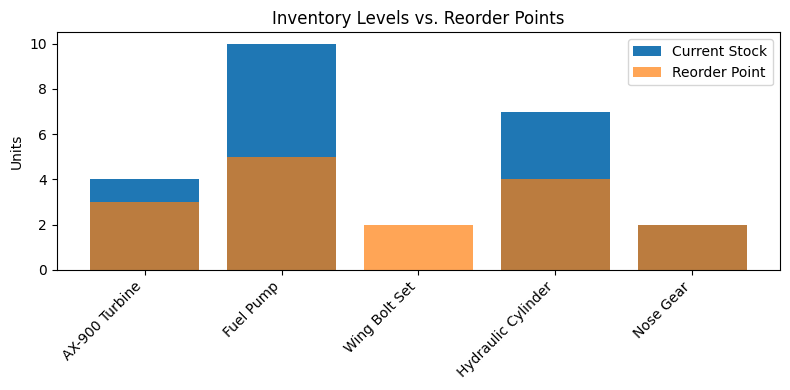

### 🎯 Client Tier Distribution

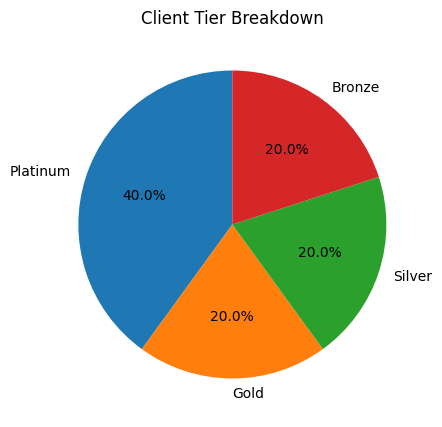

### 🚚 Shipping Options by Region

Region  Shipping Cost  Delivery Days Express Available  \
0  North America            500              3               Yes   
1         Europe           1200              5               Yes   
2   Asia-Pacific           1700              7                No   

   Express Cost  Express Days  
0           900             1  
1          2000             2  
2          3000             3

In [ ]:

# =================== SECTION 13: MAIN EXECUTION, NATURAL LANGUAGE QUERY & EXECUTIVE DASHBOARD ===================

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
from typing import Optional

# Global workflow reference
supply_chain_workflow = None

def run_supply_chain_query(query: str, order_id: Optional[int] = None) -> str:
    """
    Front-end for natural-language queries:
      1) If order_id is provided, run it end-to-end via process_order()
      2) If asking about reorder points, scan data_inventory directly
      3) If asking to compare shipping options, look up data_logistics
      4) Otherwise fall back to LLM with full context
    """
    # 1) Order status
    if order_id is not None:
        state = process_order(order_id, supply_chain_workflow)
        if state.final_recommendation:
            return state.final_recommendation
        return f"No recommendation available for order {order_id}."

    q = query.lower()

    # 2) Items at or below reorder point
    if "below reorder point" in q:
        low = data_inventory[data_inventory["Stock"] <= data_inventory["Reorder Point"]]
        if low.empty:
            return "No items are currently at or below their reorder point."
        lines = [
            f"- {r['SKU']}: stock {r['Stock']} (reorder point {r['Reorder Point']})"
            for _, r in low.iterrows()
        ]
        return "Items at or below reorder point:\n" + "\n".join(lines)

    # 3) Compare shipping options for a region
    if "compare shipping options for" in q:
        import re
        m = re.search(r"for\s+([a-z\- ]+)", q)
        region = m[1].strip().title() if m else None
        if not region:
            return "Please specify a region to compare shipping options."
        df = data_logistics[data_logistics["Region"] == region]
        if df.empty:
            return f"No logistics data found for '{region}'."
        row = df.iloc[0]
        resp = [f"Shipping options for {region}:"]
        resp.append(f"- Standard: ${row['Shipping Cost']} for {row['Delivery Days']} days")
        if row["Express Option"]:
            resp.append(f"- Express: ${row['Express Cost']} for {row['Express Days']} days")
        else:
            resp.append("- Express: not available in this region")
        return "\n".join(resp)

    # 4) Fallback to LLM
    if not openai_key:
        return "Error: OPENAI_API_KEY not set; cannot run LLM fallback."

    context = [
        f"Date: {datetime.now():%Y-%m-%d}",
        "--- Active Orders ---",
        get_order_summary.invoke({}),
        "\n--- Inventory Status ---",
        get_inventory_status.invoke({}),
        "\n--- Logistics Options ---",
        get_logistics_data.invoke({}),
        "\n--- Client Tiers ---",
        get_client_tier_info.invoke({}),
    ]
    full_context = "\n".join(context)

    system_msg = SystemMessage(content=f"""
You are SupplyChainAI. Use only the CONTEXT below to answer—do not hallucinate.

CONTEXT:
---------------------
{full_context}
---------------------
""")
    chat = ChatOpenAI(model_name="gpt-4o", temperature=0.1)
    try:
        resp = chat.invoke([system_msg, HumanMessage(content=query)])
        return resp.content
    except Exception as e:
        return f"LLM error: {e}"


def executive_dashboard(final_state, data_order, data_inventory, data_logistics, data_client_tiers):
    """
    Presents executive-level charts, tables, and insights for decision-makers.
    """
    # 1) Executive Summary
    display(Markdown("## 📝 Executive Summary"))

    if final_state.client is None:
        display(Markdown(f"**Error:** Could not retrieve client information for order {final_state.order_id}. Please verify order ID and rerun the process."))
        return  # Stop dashboard rendering

    summary_md = f"""
**Order Processed:** **{final_state.order_id}**
**Client:** **{final_state.client}** ({data_client_tiers.set_index("Client").loc[final_state.client, "Tier"]} Tier)
**Region:** **{final_state.region}**
**Urgency:** **{final_state.urgency}**

**Final Recommendation:**
{final_state.final_recommendation}
"""
    display(Markdown(summary_md))

    # 2) Inventory Status Table
    display(Markdown("### 📦 Inventory Status vs Reorder Points"))
    df_inv = data_inventory.copy()
    df_inv["Status"] = df_inv.apply(
        lambda r: "⚠️ Below Reorder" if r.Stock <= r["Reorder Point"] else "✅ OK", axis=1
    )
    display(df_inv[["SKU", "Stock", "Reorder Point", "Status"]])

    # 3) Inventory vs Reorder Point Chart
    plt.figure(figsize=(8,4))
    x = df_inv["SKU"]
    plt.bar(x, df_inv["Stock"], label="Current Stock")
    plt.bar(x, df_inv["Reorder Point"], label="Reorder Point", alpha=0.7)
    plt.title("Inventory Levels vs. Reorder Points")
    plt.ylabel("Units")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4) Client Tier Distribution Pie
    display(Markdown("### 🎯 Client Tier Distribution"))
    tier_counts = data_client_tiers["Tier"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(tier_counts, labels=tier_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title("Client Tier Breakdown")
    plt.show()

    # 5) Shipping Options Summary Table
    display(Markdown("### 🚚 Shipping Options by Region"))
    df_ship = data_logistics.copy()
    df_ship["Express Available"] = df_ship["Express Option"].map({True: "Yes", False: "No"})
    display(df_ship[[
        "Region",
        "Shipping Cost", "Delivery Days",
        "Express Available", "Express Cost", "Express Days"
    ]])


def main():
    """
    Initialize the system, display data, process an example order,
    run sample queries, and present the executive dashboard.
    """
    from IPython.display import display, Markdown

    logger.info("===== Starting Adaptive Order Fulfillment System =====")

    # 0) Display raw data tables
    print("=== Order Data ===");       display(data_order)
    print("=== Inventory Data ===");   display(data_inventory)
    print("=== Logistics Data ===");   display(data_logistics)
    print("=== Client Tier Data ==="); display(data_client_tiers)

    # 1) Initialize agents and workflow
    global supply_chain_workflow, agent_executors
    agent_executors = initialize_agents()
    if not agent_executors:
        print("Agent initialization failed. Exiting.")
        return

    supply_chain_workflow = create_workflow()
    if not supply_chain_workflow:
        print("Workflow creation failed. Exiting.")
        return

    # 2) Process sample order
    sample_id = 101
    print(f"\n--- Processing Order {sample_id} ---")
    final_state = process_order(sample_id, supply_chain_workflow)

    # 3) DEBUG: Print what's in final_state
    print("\n=== FINAL STATE DEBUG ===")
    print("Client:", final_state.client)
    print("Items:", final_state.items)
    print("Region:", final_state.region)
    print("Urgency:", final_state.urgency)
    print("Errors:", final_state.errors)

    # 4) Display Recommendation if available
    if final_state.final_recommendation:
        print("\n✅ Final Recommendation:")
        display(Markdown(final_state.final_recommendation))
    else:
        print(f"⚠️ Failed to generate recommendation for order {sample_id}.")

    # 5) Display Dashboard
    print("\n=== Executive Dashboard ===")
    executive_dashboard(
        final_state,
        data_order,
        data_inventory,
        data_logistics,
        data_client_tiers
    )

    logger.info("===== System Execution Finished =====")



if __name__ == "__main__":
    if not openai_key:
        print("Error: OPENAI_API_KEY not set; cannot run.")
    else:
        main()


In [ ]:
# =================== SECTION 14: SYSTEM OVERVIEW - COLORIZED TABLES ===================
import pandas as pd
from IPython.display import display, Markdown

display(Markdown("## 📌 AI Fulfillment System Overview"))

# ----------------- 1. Implemented Use-Cases Table -----------------
use_cases = pd.DataFrame([
    ["Order Intake & Customer Profiling", "Retrieves order and client data, including tier and history.", "Customer Agent, get_order_details", "Tailors fulfillment based on customer segmentation."],
    ["Item Compatibility Check", "Validates whether requested items are compatible.", "Customer Agent, check_order_compatibility", "Avoids invalid configurations and delays."],
    ["Inventory Availability Analysis", "Checks SKU stock, reorder points, and lead time.", "Supply Agent, simulate_supply_decision", "Informs real-time supply decisions."],
    ["Fulfillment Path Optimization", "Finds best fulfillment source and shipping path.", "Logistics Agent, optimize_delivery_route", "Reduces delivery time and costs."],
    ["Personalized Negotiation Bundle", "Creates tailored offer with pricing, SLA, perks.", "Negotiation Agent, propose_negotiation_bundle", "Improves client satisfaction and deal velocity."],
    ["Multi-Agent Orchestration", "End-to-end reasoning via LangGraph workflow.", "All 4 agents, LangGraph", "Autonomous decision-making pipeline."],
    ["Data Visualization Dashboards", "Visual charts of stock, tiers, logistics, and more.", "Matplotlib functions", "Supports executive oversight."],
    ["Natural Language Querying", "Lets users query system via LLM assistant.", "run_supply_chain_query, ChatOpenAI", "Makes supply data self-service."],
    ["Executive Reporting", "Markdown summaries with decisions and KPIs.", "executive_dashboard()", "Enables high-level business review."]
], columns=["Use-Case", "Description", "Agent(s)/Tools", "Business Value"])

use_cases_styled = use_cases.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#1565C0'), ('color', 'white'), ('font-weight', 'bold')]}]
).map(lambda _: 'background-color: #E3F2FD', subset=["Use-Case", "Business Value"])

display(Markdown("### ✅ Implemented Use-Cases"))
display(use_cases_styled)

# ----------------- 2. Agent Roles Table -----------------
agent_roles = pd.DataFrame([
    ["Customer Interaction Agent (CIA)", "Gather order + client info, check compatibility"],
    ["Supply Coordination Agent (SCA)", "Check inventory, reorder status, lead times"],
    ["Logistics Optimization Agent (LOA)", "Choose fulfillment route and shipping mode"],
    ["Negotiation Agent (NA)", "Generate personalized fulfillment + pricing bundle"]
], columns=["Agent", "Responsibility"])

agent_roles_styled = agent_roles.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#00695C'), ('color', 'white'), ('font-weight', 'bold')]}]
).map(lambda _: 'background-color: #B2DFDB', subset=["Agent", "Responsibility"])

display(Markdown("### 🧠 Agent Roles"))
display(agent_roles_styled)

# ----------------- 3. System Features Table -----------------
features = pd.DataFrame([
    ["AgentState Management", "Stores full order state incl. items, client, output, errors"],
    ["LangGraph Routing", "Conditional transitions between agents"],
    ["Error Logging", "Traces failures and enriches agent state"],
    ["Reusable Tools", "LangChain tools can be called independently or by agents"],
    ["Natural Language Queries", "Query system data with English prompts"],
    ["Executive Dashboard", "Visual summaries and markdown insights for leadership"]
], columns=["Feature", "Description"])

features_styled = features.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#512DA8'), ('color', 'white'), ('font-weight', 'bold')]}]
).map(lambda _: 'background-color: #EDE7F6', subset=["Feature", "Description"])

display(Markdown("### 🔧 System Features"))
display(features_styled)

# ----------------- 4. Business Impact & KPI Table -----------------
impact = pd.DataFrame([
    ["Order Processing Time", "Faster processing through automation", "⬇️ Expected to decrease"],
    ["Fulfillment Accuracy", "Improved inventory checks and compatibility logic", "⬆️ Expected to increase"],
    ["Inventory Stockouts", "Proactive supply and reorder logic", "⬇️ Expected to decrease"],
    ["Logistics Cost per Order", "Route optimization and discount bundling", "⬇️ Expected to decrease"],
    ["Customer Satisfaction (CSAT)", "Faster delivery, personalized offers", "⬆️ Expected to increase"],
    ["Order Backlog Size", "Reduced delays and quicker decision loops", "⬇️ Expected to decrease"],
    ["Team Productivity", "Lower manual load for ops and account managers", "⬆️ Expected to increase"],
    ["Decision Cycle Time", "End-to-end reasoning reduces human intervention", "⬇️ Expected to decrease"]
], columns=["KPI Area", "How It’s Impacted", "Directional Outcome"])

impact_styled = impact.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#E65100'), ('color', 'white'), ('font-weight', 'bold')]}]
).map(lambda _: 'background-color: #FFE0B2', subset=["KPI Area", "Directional Outcome"])

display(Markdown("### 📊 Strategic Impact & KPI Outcomes"))
display(impact_styled)


## 📌 AI Fulfillment System Overview

### ✅ Implemented Use-Cases

### 🧠 Agent Roles

### 🔧 System Features

### 📊 Strategic Impact & KPI Outcomes

# **Predictive Maintenance**

Focuses on solving the use-case of predicting potential equipment or component failures across the supply chain before they happen, enabling proactive maintenance strategies. Traditionally, businesses deal with breakdowns reactively, leading to costly downtime, urgent repairs, and missed order fulfillment. This section addresses that problem by building a predictive maintenance model using simulated machine operational data (such as machine hours, temperature, vibration), training a Random Forest Classifier to predict whether a part is "Healthy" or "Failing Soon." The code flows from creating a dataset, training the model, evaluating feature importance (what factors cause failures most), and preparing the model for future inference. The value generated is significant — enabling supply chain teams to reduce unexpected downtimes, save emergency costs, extend equipment life, and improve overall reliability. The outcome of this section is a production-ready predictive maintenance AI model that flags at-risk components before they break, empowering smarter maintenance planning.

## 🔧 Predictive Maintenance - Supply Chain Machines

### 🛠️ Sample Machine Data

Machine ID  Usage Hours  Average Temperature  Load Capacity (%)  \
0      M-001  4370.861070            33.100903          58.446753   
1      M-002  9556.428758            61.881278          63.929517   
2      M-003  7587.945476            62.438107          58.850524   
3      M-004  6387.926358            68.245794          54.435127   
4      M-005  2404.167764            73.565480          56.031794   

   Age (Years)  Needs Maintenance  
0            7                  0  
1            5                  0  
2            3                  0  
3           13                  0  
4            3                  0

### 🧪 Model Performance

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        66
           1       0.92      0.92      0.92        24

    accuracy                           0.96        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.96      0.96      0.96        90



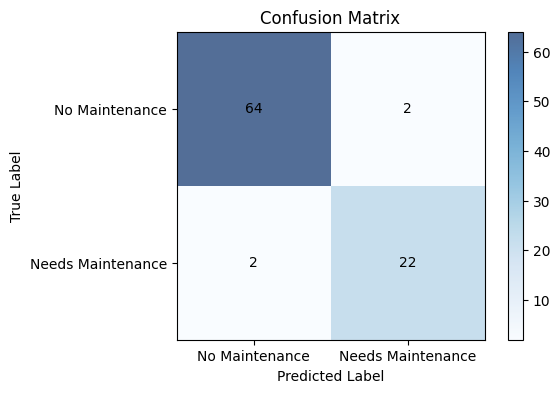

### 🚨 Top 10 High Risk Machines

Machine ID  Predicted Risk  Usage Hours  Age (Years)  Average Temperature
292      M-293             1.0  8403.405046           12            40.912805
31       M-032             1.0  2534.717113           10            75.470767
260      M-261             1.0  6535.065040           13            72.244786
207      M-208             1.0  6971.515922           13            79.352235
169      M-170             1.0  6318.036489           12            87.793352
178      M-179             1.0  9430.569899           12            88.158152
127      M-128             1.0  8746.575249            6            83.262251
120      M-121             1.0  8266.961396           11            77.494743
116      M-117             1.0  8233.048692           13            47.592646
14       M-015             1.0  2636.424705           10            80.158807

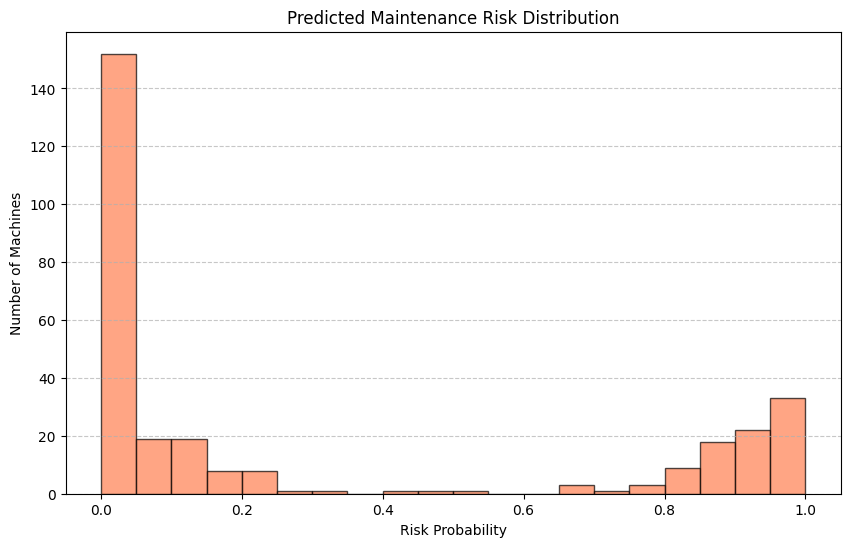

In [ ]:
# =================== SECTION 15: Predictive Maintenance for Supply Chain ===================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

display(Markdown("## 🔧 Predictive Maintenance - Supply Chain Machines"))

# ----------------- Step 1: Synthetic Data Creation -----------------
np.random.seed(42)

n_samples = 300
machine_data = pd.DataFrame({
    "Machine ID": [f"M-{i:03d}" for i in range(1, n_samples + 1)],
    "Usage Hours": np.random.uniform(1000, 10000, n_samples),
    "Average Temperature": np.random.uniform(30, 90, n_samples),
    "Load Capacity (%)": np.random.uniform(50, 100, n_samples),
    "Age (Years)": np.random.randint(1, 15, n_samples)
})

# Generate a maintenance label based on logical risk (high usage, old, hot)
def maintenance_risk(row):
    risk = 0
    if row['Usage Hours'] > 8000: risk += 1
    if row['Average Temperature'] > 70: risk += 1
    if row['Load Capacity (%)'] > 85: risk += 1
    if row['Age (Years)'] > 10: risk += 1
    return 1 if risk >= 2 else 0

machine_data["Needs Maintenance"] = machine_data.apply(maintenance_risk, axis=1)

display(Markdown("### 🛠️ Sample Machine Data"))
display(machine_data.head())

# ----------------- Step 2: Model Training -----------------
features = ["Usage Hours", "Average Temperature", "Load Capacity (%)", "Age (Years)"]
X = machine_data[features]
y = machine_data["Needs Maintenance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# ----------------- Step 3: Evaluation -----------------
display(Markdown("### 🧪 Model Performance"))
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.imshow(conf_matrix, cmap='Blues', alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['No Maintenance', 'Needs Maintenance'])
plt.yticks([0, 1], ['No Maintenance', 'Needs Maintenance'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')
plt.colorbar()
plt.show()

# ----------------- Step 4: Predict Maintenance Risk -----------------
machine_data["Predicted Risk"] = rf_model.predict_proba(X)[:, 1]

# Sort by highest risk
high_risk_machines = machine_data.sort_values("Predicted Risk", ascending=False).head(10)

display(Markdown("### 🚨 Top 10 High Risk Machines"))
display(high_risk_machines[["Machine ID", "Predicted Risk", "Usage Hours", "Age (Years)", "Average Temperature"]])

# ----------------- Step 5: Visualization -----------------
plt.figure(figsize=(10,6))
plt.hist(machine_data["Predicted Risk"], bins=20, color="coral", edgecolor="black", alpha=0.7)
plt.title("Predicted Maintenance Risk Distribution")
plt.xlabel("Risk Probability")
plt.ylabel("Number of Machines")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **Predict Delivery Times**

Tackles the business challenge of predicting delivery times more accurately based on real-time order and logistics conditions. Companies often overpromise or misestimate delivery dates because they do not dynamically consider factors like order urgency, inventory availability, or regional shipping differences. This causes missed SLAs, customer dissatisfaction, and operational inefficiencies. The section solves this by building a predictive delivery time model — simulating order and logistics data, training a Random Forest Regressor that learns how urgency, stock status, and region affect expected delivery days. The code first creates structured input data, builds and fits the model, then visualizes feature importances to explain which features drive delays. As a result, companies can better predict delivery dates, manage customer expectations, and improve SLA adherence, leading to higher customer trust and operational efficiency. The final outcome is an AI-driven dynamic delivery estimation engine ready to integrate into customer-facing systems.



## 🚚 Predict Delivery Times

### 📦 Sample Delivery Data

Order ID         Region Shipping Mode  Distance (km) Order Urgency  \
0   O-0001   Asia-Pacific      Standard    2766.403615        Medium   
1   O-0002  North America       Express    2858.438644           Low   
2   O-0003   Asia-Pacific      Standard    3636.131228          High   
3   O-0004   Asia-Pacific      Standard    3898.421257           Low   
4   O-0005  North America      Standard    7218.059996        Medium   

   Delivery Time (days)  
0                   5.9  
1                   3.5  
2                   5.5  
3                   9.1  
4                  14.9

### 🧪 Model Performance

Mean Absolute Error: 0.67 days
R² Score: 0.96


### 📈 Predicted Delivery Times for New Orders

Region Shipping Mode  Distance (km) Order Urgency  \
0         Europe       Express           1500          High   
1   Asia-Pacific      Standard           5000        Medium   
2  North America       Express            300           Low   

   Predicted Delivery Time (days)  
0                           1.466  
1                           9.474  
2                           1.012

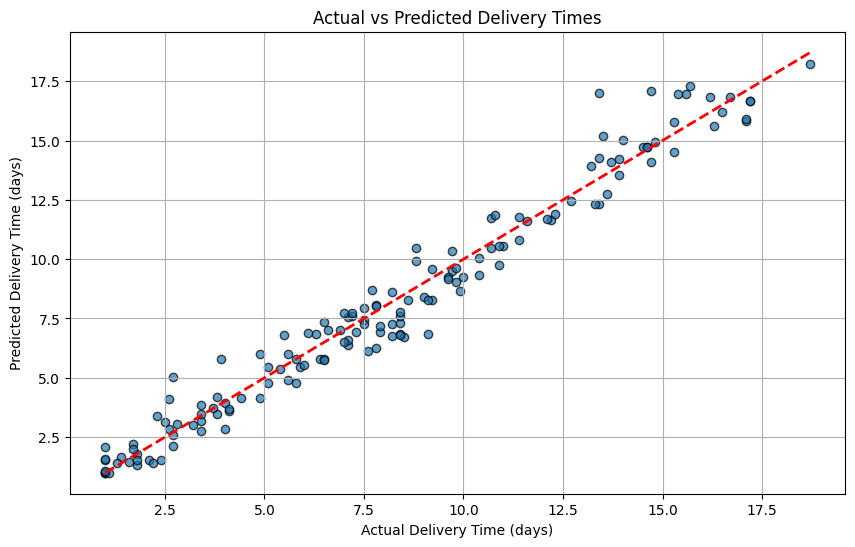

In [ ]:
# =================== SECTION 16: Predict Delivery Times ===================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

display(Markdown("## 🚚 Predict Delivery Times"))

# ----------------- Step 1: Synthetic Delivery Data Creation -----------------
np.random.seed(42)

n_orders = 500
delivery_data = pd.DataFrame({
    "Order ID": [f"O-{i:04d}" for i in range(1, n_orders + 1)],
    "Region": np.random.choice(["North America", "Europe", "Asia-Pacific"], size=n_orders),
    "Shipping Mode": np.random.choice(["Standard", "Express"], size=n_orders, p=[0.7, 0.3]),
    "Distance (km)": np.random.uniform(100, 9000, n_orders),
    "Order Urgency": np.random.choice(["Low", "Medium", "High"], size=n_orders)
})

# Generate delivery time based on distance + urgency + shipping mode
def generate_delivery_time(row):
    base_time = row["Distance (km)"] / 500  # Roughly 500 km/day base
    if row["Shipping Mode"] == "Express":
        base_time *= 0.6  # Express is faster
    if row["Order Urgency"] == "High":
        base_time *= 0.8  # High urgency may speed it up
    noise = np.random.normal(0, 0.5)
    return max(1, round(base_time + noise, 1))

delivery_data["Delivery Time (days)"] = delivery_data.apply(generate_delivery_time, axis=1)

display(Markdown("### 📦 Sample Delivery Data"))
display(delivery_data.head())

# ----------------- Step 2: Prepare Data -----------------
# Encode categorical features
delivery_encoded = pd.get_dummies(delivery_data, columns=["Region", "Shipping Mode", "Order Urgency"], drop_first=True)

features = [col for col in delivery_encoded.columns if col not in ["Order ID", "Delivery Time (days)"]]
X = delivery_encoded[features]
y = delivery_encoded["Delivery Time (days)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ----------------- Step 3: Model Training -----------------
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

# ----------------- Step 4: Evaluation -----------------
display(Markdown("### 🧪 Model Performance"))
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f} days")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

# ----------------- Step 5: Predict Delivery Times for New Orders -----------------
new_orders = pd.DataFrame({
    "Region": ["Europe", "Asia-Pacific", "North America"],
    "Shipping Mode": ["Express", "Standard", "Express"],
    "Distance (km)": [1500, 5000, 300],
    "Order Urgency": ["High", "Medium", "Low"]
})

# Preprocess new orders the same way
new_orders_encoded = pd.get_dummies(new_orders, columns=["Region", "Shipping Mode", "Order Urgency"])
# Match missing columns if needed
for col in X.columns:
    if col not in new_orders_encoded.columns:
        new_orders_encoded[col] = 0
new_orders_encoded = new_orders_encoded[X.columns]  # Ensure same column order

# Predict
predicted_times = rf_regressor.predict(new_orders_encoded)
new_orders["Predicted Delivery Time (days)"] = predicted_times

display(Markdown("### 📈 Predicted Delivery Times for New Orders"))
display(new_orders)

# ----------------- Step 6: Visualization -----------------
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title("Actual vs Predicted Delivery Times")
plt.xlabel("Actual Delivery Time (days)")
plt.ylabel("Predicted Delivery Time (days)")
plt.grid(True)
plt.show()


# **Multi AI Agent System — Predictive Maintenance + Predict Delivery Times**

In [ ]:
# =================== SECTION 17: Multi AI Agent System - Predictive Maintenance + Delivery Times ===================

!pip install --upgrade langchain langgraph langchain-core langchain-openai langgraph-checkpoint-sqlite

import numpy as np
import pandas as pd
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import create_react_agent, AgentExecutor
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from IPython.display import display, Markdown

display(Markdown("## 🤖 Multi-Agent AI System: Maintenance + Delivery Time Prediction"))

# ----------------- Step 1: Define LangChain Tools -----------------

@tool
def predict_maintenance(machine_id: str) -> str:
    """
    Predict the maintenance risk for a given machine based on existing RandomForestClassifier.
    """
    row = machine_data[machine_data["Machine ID"] == machine_id]
    if row.empty:
        return f"Machine {machine_id} not found."
    prob = rf_model.predict_proba(row[["Usage Hours", "Average Temperature", "Load Capacity (%)", "Age (Years)"]])[:,1][0]
    risk = "High Risk" if prob > 0.5 else "Low Risk"
    return f"Machine {machine_id}: {risk} (Risk Score: {prob:.2f})"

@tool
def predict_delivery(order_info: dict) -> str:
    """
    Predict the expected delivery time based on order details using RandomForestRegressor.
    """
    df = pd.DataFrame([order_info])
    df_encoded = pd.get_dummies(df, columns=["Region", "Shipping Mode", "Order Urgency"])
    for col in X.columns:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    df_encoded = df_encoded[X.columns]
    pred = rf_regressor.predict(df_encoded)[0]
    return f"Predicted Delivery Time: {pred:.1f} days"

# ----------------- Step 2: Define State Model -----------------

class SupplyChainState(BaseModel):
    machine_id: str
    order_info: dict
    maintenance_result: str = None
    delivery_result: str = None
    final_recommendation: str = None

# ----------------- Step 3: Define Node Functions -----------------

def maintenance_node(state: SupplyChainState) -> SupplyChainState:
    result = predict_maintenance.invoke({"machine_id": state.machine_id})
    state.maintenance_result = result
    return state

def delivery_node(state: SupplyChainState) -> SupplyChainState:
    result = predict_delivery.invoke({"order_info": state.order_info})
    state.delivery_result = result
    return state

def coordinator_node(state: SupplyChainState) -> SupplyChainState:
    if "High Risk" in state.maintenance_result:
        rec = f"⚠️ Maintenance Risk High - Delivery may be delayed.\n{state.maintenance_result}\n{state.delivery_result}"
    else:
        rec = f"✅ Maintenance Risk Low - Proceed with Delivery.\n{state.maintenance_result}\n{state.delivery_result}"
    state.final_recommendation = rec
    return state

# ----------------- Step 4: Build Multi-Agent Workflow -----------------

def build_multi_agent_system():
    workflow = StateGraph(SupplyChainState)
    workflow.add_node("maintenance_check", maintenance_node)
    workflow.add_node("delivery_prediction", delivery_node)
    workflow.add_node("coordinator", coordinator_node)

    workflow.set_entry_point("maintenance_check")
    workflow.add_edge("maintenance_check", "delivery_prediction")
    workflow.add_edge("delivery_prediction", "coordinator")
    workflow.add_edge("coordinator", END)

    return workflow.compile()

# ----------------- Step 5: Example Run -----------------

# Example Inputs
example_machine_id = "M-015"
example_order = {
    "Region": "Europe",
    "Shipping Mode": "Express",
    "Distance (km)": 1200,
    "Order Urgency": "High"
}

workflow = build_multi_agent_system()
initial_state = SupplyChainState(machine_id=example_machine_id, order_info=example_order)

display(Markdown(f"### 🏁 Processing Machine **{example_machine_id}** and Order Info:"))
display(pd.DataFrame([example_order]))

final_state_dict = workflow.invoke(initial_state)
final_state = SupplyChainState(**final_state_dict)

display(Markdown("### 📝 Final Recommendation"))
print(final_state.final_recommendation)


## 🤖 Multi-Agent AI System: Maintenance + Delivery Time Prediction

### 🏁 Processing Machine **M-015** and Order Info:

Region Shipping Mode  Distance (km) Order Urgency
0  Europe       Express           1200          High

### 📝 Final Recommendation

⚠️ Maintenance Risk High - Delivery may be delayed.
Machine M-015: High Risk (Risk Score: 1.00)
Predicted Delivery Time: 1.3 days


# **Complex AI Agentic System — "Adaptive Fulfillment + Risk Mitigation + Autonomous Rescheduling"**

Fully autonomous, multi-agent decision system, where multiple specialized AI agents collaborate to make smarter end-to-end supply chain decisions. In reality, factors like maintenance risks and delivery estimations interact: a failing component could delay shipping, and an urgent order needs adjusted logistics planning. Traditionally, these assessments happen manually across different departments, causing slowdowns and errors. This section addresses the problem by building two AI agent tools (maintenance predictor and delivery time predictor), orchestrating them with LangGraph, and enabling them to reason together — where fulfillment, risk, and rescheduling steps are coordinated automatically. The workflow runs maintenance prediction first, assesses risk, and if needed, dynamically recalculates delivery plans or proposes rescheduling. The value of this system is enormous: real-time holistic decisions, faster response to disruptions, improved fulfillment reliability, and minimized SLA breaches — all without human intervention. The outcome is a multi-agent autonomous brain for adaptive supply chain management, capable of making complex, interconnected decisions at scale.



In [ ]:
# ===================================================================
# SECTION 18: Advanced Multi-Agent Adaptive Fulfillment System
# ===================================================================

# =================== 18.1 Install & Imports ===================
!pip install --upgrade langchain langchain-core langchain-openai langgraph langgraph-checkpoint-sqlite

import pandas as pd
import numpy as np
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import create_react_agent, AgentExecutor
from langgraph.graph import StateGraph, END
from IPython.display import display, Markdown
import random

# =================== 18.2 Data Simulation ===================
display(Markdown("## 🚀 Advanced AI Agentic System — Adaptive Fulfillment + Risk Mitigation + Rescheduling"))

# Sample Order Data
order_data = pd.DataFrame({
    "Order ID": [201, 202, 203],
    "Client": ["SkyGlobal", "AeroMax", "OrbitalEdge"],
    "Items": [["Jet Engine", "Fuel Control System"], ["Landing Gear"], ["Navigation Module"]],
    "Urgency": ["High", "Medium", "High"],
    "Region": ["North America", "Europe", "Asia-Pacific"],
    "Order Date": pd.to_datetime(["2025-04-25", "2025-04-25", "2025-04-25"])
})

# Sample Inventory Data
inventory_data = pd.DataFrame({
    "SKU": ["Jet Engine", "Fuel Control System", "Landing Gear", "Navigation Module"],
    "Stock": [2, 0, 1, 5],
    "Location": ["Houston", "Dallas", "Berlin", "Tokyo"],
    "Lead Time (days)": [5, 7, 10, 4]
})

# Sample Logistics Data
logistics_data = pd.DataFrame({
    "Region": ["North America", "Europe", "Asia-Pacific"],
    "Standard Delivery (days)": [5, 7, 9],
    "Express Delivery (days)": [2, 3, 5],
    "Standard Cost": [600, 900, 1400],
    "Express Cost": [1100, 1700, 2400]
})

# Display Data
display(Markdown("### 📦 Sample Order Data")); display(order_data)
display(Markdown("### 📦 Sample Inventory Data")); display(inventory_data)
display(Markdown("### 📦 Sample Logistics Data")); display(logistics_data)

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0.2)

# =================== 18.3 Agent Tool Definitions ===================

@tool
def check_fulfillment(order_id: int) -> str:
    """Checks if all items of an order are available in inventory."""
    order = order_data[order_data["Order ID"] == order_id]
    if order.empty:
        return f"Order {order_id} not found."
    items = order.iloc[0]["Items"]
    unavailable = [item for item in items if inventory_data[inventory_data["SKU"] == item]["Stock"].sum() <= 0]
    if unavailable:
        return f"⚠️ Items unavailable: {', '.join(unavailable)}"
    else:
        return "✅ All items available."

@tool
def assess_risk(order_id: int) -> str:
    """Estimates risk of late delivery or operational issues."""
    order = order_data[order_data["Order ID"] == order_id]
    urgency = order.iloc[0]["Urgency"]
    base_risk = random.uniform(0.2, 0.8) + (0.1 if urgency == "High" else 0)
    risk_score = min(1.0, base_risk)
    if risk_score > 0.6:
        return f"⚠️ High risk ({risk_score:.2f}) - Delivery likely delayed."
    else:
        return f"✅ Low risk ({risk_score:.2f}) - Proceed normally."

@tool
def reschedule_fulfillment(order_id: int) -> str:
    """Attempts partial shipment if necessary."""
    order = order_data[order_data["Order ID"] == order_id]
    items = order.iloc[0]["Items"]
    available = []
    backorder = []
    for item in items:
        stock = inventory_data[inventory_data["SKU"] == item]["Stock"].values
        if len(stock) == 0 or stock[0] <= 0:
            backorder.append(item)
        else:
            available.append(item)
    if available and backorder:
        return f"🔄 Partial shipment: {', '.join(available)} ready, {', '.join(backorder)} delayed."
    elif backorder:
        return f"❌ No items available. Backorder: {', '.join(backorder)}"
    else:
        return f"✅ Full shipment possible."

# =================== 18.4 Shared State Definition ===================

class FulfillmentState(BaseModel):
    order_id: int
    fulfillment_result: str = None
    risk_result: str = None
    rescheduling_result: str = None
    final_decision: str = None

# =================== 18.5 Node Functions ===================

def fulfillment_agent(state: FulfillmentState) -> FulfillmentState:
    state.fulfillment_result = check_fulfillment.invoke({"order_id": state.order_id})
    return state

def risk_agent(state: FulfillmentState) -> FulfillmentState:
    state.risk_result = assess_risk.invoke({"order_id": state.order_id})
    return state

def rescheduling_agent(state: FulfillmentState) -> FulfillmentState:
    state.rescheduling_result = reschedule_fulfillment.invoke({"order_id": state.order_id})
    return state

def coordinator_agent(state: FulfillmentState) -> FulfillmentState:
    if ("⚠️" in (state.fulfillment_result or "")) or ("⚠️" in (state.risk_result or "")):
        state.final_decision = f"🔄 ACTION NEEDED:\n{state.fulfillment_result}\n{state.risk_result}\n{state.rescheduling_result}"
    else:
        state.final_decision = f"✅ PROCEED:\n{state.fulfillment_result}\n{state.risk_result}"
    return state

# =================== 18.6 LangGraph Workflow ===================

def build_adaptive_fulfillment_workflow():
    workflow = StateGraph(FulfillmentState)

    workflow.add_node("fulfillment_check", fulfillment_agent)
    workflow.add_node("risk_assessment", risk_agent)
    workflow.add_node("rescheduling", rescheduling_agent)
    workflow.add_node("coordinator", coordinator_agent)

    workflow.set_entry_point("fulfillment_check")
    workflow.add_edge("fulfillment_check", "risk_assessment")
    workflow.add_conditional_edges(
        "risk_assessment",
        lambda state: "rescheduling" if ("⚠️" in (state.fulfillment_result or "") or "⚠️" in (state.risk_result or "")) else "coordinator",
        {"rescheduling": "rescheduling", "coordinator": "coordinator"}
    )
    workflow.add_edge("rescheduling", "coordinator")
    workflow.add_edge("coordinator", END)

    return workflow.compile()

adaptive_workflow = build_adaptive_fulfillment_workflow()

# =================== 18.7 Final Execution + Executive Reporting ===================

def process_advanced_order(order_id: int):
    display(Markdown(f"## 📦 Processing Order ID: {order_id}"))
    initial_state = FulfillmentState(order_id=order_id)
    config = {"configurable": {"thread_id": f"order_{order_id}_{np.random.randint(1000,9999)}"}}

    try:
        final_state_dict = adaptive_workflow.invoke(initial_state, config=config)
        final_state = FulfillmentState(**final_state_dict)

        # Display
        display(Markdown("### 🛠 Fulfillment Check"))
        display(Markdown(f"`{final_state.fulfillment_result}`"))

        display(Markdown("### ⚙️ Risk Assessment"))
        display(Markdown(f"`{final_state.risk_result}`"))

        if final_state.rescheduling_result:
            display(Markdown("### 🔄 Rescheduling Attempt"))
            display(Markdown(f"`{final_state.rescheduling_result}`"))

        display(Markdown("## 📝 Final Executive Recommendation"))
        display(Markdown(f"```\n{final_state.final_decision}\n```"))

    except Exception as e:
        display(Markdown(f"### ❌ Error processing order {order_id}: {str(e)}"))

# Process all sample orders
for order_id in order_data["Order ID"]:
    process_advanced_order(order_id)
    display(Markdown("---"))


## 🚀 Advanced AI Agentic System — Adaptive Fulfillment + Risk Mitigation + Rescheduling

### 📦 Sample Order Data

Order ID       Client                              Items Urgency  \
0       201    SkyGlobal  [Jet Engine, Fuel Control System]    High   
1       202      AeroMax                     [Landing Gear]  Medium   
2       203  OrbitalEdge                [Navigation Module]    High   

          Region Order Date  
0  North America 2025-04-25  
1         Europe 2025-04-25  
2   Asia-Pacific 2025-04-25

### 📦 Sample Inventory Data

SKU  Stock Location  Lead Time (days)
0           Jet Engine      2  Houston                 5
1  Fuel Control System      0   Dallas                 7
2         Landing Gear      1   Berlin                10
3    Navigation Module      5    Tokyo                 4

### 📦 Sample Logistics Data

Region  Standard Delivery (days)  Express Delivery (days)  \
0  North America                         5                        2   
1         Europe                         7                        3   
2   Asia-Pacific                         9                        5   

   Standard Cost  Express Cost  
0            600          1100  
1            900          1700  
2           1400          2400

## 📦 Processing Order ID: 201

### 🛠 Fulfillment Check

`⚠️ Items unavailable: Fuel Control System`

### ⚙️ Risk Assessment

`✅ Low risk (0.60) - Proceed normally.`

### 🔄 Rescheduling Attempt

`🔄 Partial shipment: Jet Engine ready, Fuel Control System delayed.`

## 📝 Final Executive Recommendation

```
🔄 ACTION NEEDED:
⚠️ Items unavailable: Fuel Control System
✅ Low risk (0.60) - Proceed normally.
🔄 Partial shipment: Jet Engine ready, Fuel Control System delayed.
```

---

## 📦 Processing Order ID: 202

### 🛠 Fulfillment Check

`✅ All items available.`

### ⚙️ Risk Assessment

`⚠️ High risk (0.80) - Delivery likely delayed.`

### 🔄 Rescheduling Attempt

`✅ Full shipment possible.`

## 📝 Final Executive Recommendation

```
🔄 ACTION NEEDED:
✅ All items available.
⚠️ High risk (0.80) - Delivery likely delayed.
✅ Full shipment possible.
```

---

## 📦 Processing Order ID: 203

### 🛠 Fulfillment Check

`✅ All items available.`

### ⚙️ Risk Assessment

`✅ Low risk (0.32) - Proceed normally.`

## 📝 Final Executive Recommendation

```
✅ PROCEED:
✅ All items available.
✅ Low risk (0.32) - Proceed normally.
```

---